In [1]:
# [셀 1] 한글 폰트 설치 및 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 깨짐 방지
print("한글 폰트 설치 완료. 그래프가 깨지면 [런타임] -> [런타임 다시 시작] 후 진행하세요.")

Sudo가 이 컴퓨터에서 사용하지 않도록 설정되어 있습니다. 사용하도록 설정하려면 으로 이동하세요. ]8;;ms-settings:developers\Developer Settings page]8;;\ 설정 앱의
Sudo가 이 컴퓨터에서 사용하지 않도록 설정되어 있습니다. 사용하도록 설정하려면 으로 이동하세요. ]8;;ms-settings:developers\Developer Settings page]8;;\ 설정 앱의


'rm'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


한글 폰트 설치 완료. 그래프가 깨지면 [런타임] -> [런타임 다시 시작] 후 진행하세요.


#데이터 불러오기 및 전처리

In [2]:
# [셀 2] 라이브러리 로드 및 데이터 불러오기
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore') # 불필요한 경고 메시지 숨기기

# =========================================================
# ▼ [중요] 아래 파일명을 본인의 엑셀 파일명으로 수정하세요 ▼
filename = '/content/exp - 설문지 응답 시트1 (1).csv'
# =========================================================

try:
    df = pd.read_csv(filename)
    print(f"✅ 파일을 성공적으로 읽었습니다! 총 {len(df)}명의 데이터가 있습니다.")
except FileNotFoundError:
    print(f"""❌ 파일을 찾을 수 없습니다. '{filename}' 파일이 코랩에 업로드되었는지 확인하세요.
엑셀 파일이 아닌 경우, 'pd.read_excel' 대신 'pd.read_csv' 등으로 변경하세요.""")

# [전처리] 컬럼명에서 '[1-1]' 같은 식별자만 찾아서 매칭하기 쉽게 변경한다고 가정하지 않고
# 기존 컬럼명에 해당 번호가 포함되어 있으면 데이터를 가져오는 방식을 씁니다.

# 나이 컬럼([1-2]) 숫자 변환 (혹시 '24세' 처럼 문자가 섞여 있을까봐 처리)
# 해당 컬럼을 찾아서 숫자만 남기고 변환
age_col = [c for c in df.columns if '[1-2]' in c][0]
df[age_col] = pd.to_numeric(df[age_col].astype(str).str.extract('(\d+)')[0], errors='coerce')

print("데이터 전처리 완료.")
df.head(3) # 데이터 앞부분 3줄 확인

<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
C:\Users\choke\AppData\Local\Temp\ipykernel_24788\2586814325.py:25: SyntaxWarning: invalid escape sequence '\d'
  df[age_col] = pd.to_numeric(df[age_col].astype(str).str.extract('(\d+)')[0], errors='coerce')


❌ 파일을 찾을 수 없습니다. '/content/exp - 설문지 응답 시트1 (1).csv' 파일이 코랩에 업로드되었는지 확인하세요.
엑셀 파일이 아닌 경우, 'pd.read_excel' 대신 'pd.read_csv' 등으로 변경하세요.


NameError: name 'df' is not defined

# 연령대 그룹 나누기 (핵심)

In [ ]:
# [셀 3] 연령대 그룹화 (Age Grouping)

# 나이 기준 설정 함수
def get_age_group(age):
    if pd.isna(age): return np.nan
    age = int(age)

    if age <= 25:
        return '20대 초반'
    elif 26 <= age <= 29:
        return '20대 중후반'
    elif age >= 30:
        return '30대  이상' # 30대 이상 포괄
    else:
        return '기타'

# 그룹 컬럼 생성
df['Age_Group'] = df[age_col].apply(get_age_group)

# 그룹별 인원수 확인
print("=== 연령대별 표본 수 ===")
print(df['Age_Group'].value_counts())

# 만약 특정 그룹 인원이 너무 적으면(2명 미만) 분석이 안 될 수 있습니다.

=== 연령대별 표본 수 ===
Age_Group
20대 초반     52
30대  이상    30
20대 중후반    18
Name: count, dtype: int64


# 섹터 정의 및 평균 점수 계산

In [ ]:
# [셀 4] 섹터별 문항 정의 및 평균 계산

# 전체 컬럼 리스트
cols = df.columns.tolist()

# 문항 번호로 컬럼 찾는 함수
def find_cols(prefix_list):
    found = []
    for prefix in prefix_list:
        # 컬럼명에 '[3-1]' 등이 포함된 것을 찾음
        matched = [c for c in cols if f'[{prefix}]' in c]
        found.extend(matched)
    return found

# 1. SNS 이용량 관련 컬럼 전처리 (문자열 -> 숫자)
# 컬럼명 찾기
sns_freq_col = find_cols(['2-3'])[0]
sns_time_col = find_cols(['2-4'])[0]

# 매핑 딕셔너리 정의
sns_freq_mapping = {
    '필요시 검색': 1,
    '가끔씩 (2~5회)': 2,
    '수시로 접속 (10회 이상)': 3,
    '거의 습관적으로 자주 (30회 이상)': 4,
    '하루 종일 접속해놓고 있다': 5
}

sns_time_mapping = {
    '10분 미만': 0.5, # 0.5시간
    '30분~1시간 미만': 0.75, # 0.75시간
    '1~2시간 미만': 1.5,
    '2~4시간 미만': 3,
    '4~5시간 미만': 4.5,
    '5시간 이상': 6
}

# 새로운 숫자 컬럼 생성
df['SNS_Freq_Numeric'] = df[sns_freq_col].map(sns_freq_mapping)
df['SNS_Time_Numeric'] = df[sns_time_col].map(sns_time_mapping)

# 2. 섹터별 문항 정의 (역채점 문항 제거됨)
sector_map = {
    "SNS 이용량": ['SNS_Freq_Numeric', 'SNS_Time_Numeric'], # 이제 숫자형 컬럼 사용
    "충동구매 성향": find_cols(['3-1', '3-2', '3-3', '3-4', '3-5', '3-28', '3-29']),
    "사회적 비교": find_cols(['3-7', '3-8', '3-9', '3-10', '3-11']),
    "쇼핑 후회/태도": find_cols(['3-13', '3-14', '3-15', '3-16', '3-25', '3-26', '3-27']),
    "광고 인식/신뢰": find_cols([f'3-{i}' for i in range(17, 25)] + [f'4-{i}' for i in range(1, 13)]),
    "구매 의도": find_cols([f'4-{i}' for i in range(13, 28)])
}

# 3. 평균 점수 계산 (Row Mean)
factor_names = []
for name, columns in sector_map.items():
    if not columns:
        print(f"⚠️ 경고: '{name}'에 해당하는 컬럼을 찾지 못했습니다.")
        continue
    # 해당 컬럼들의 평균을 내서 새 변수 생성
    df[f'{name}_Mean'] = df[columns].mean(axis=1)
    factor_names.append(f'{name}_Mean')

print("✅ 요인별 평균 점수 계산 완료!")

✅ 요인별 평균 점수 계산 완료!


# ANOVA 분석 (나이대별 차이 검증)

In [ ]:
# [셀 5] 연령대별 차이 분석 (ANOVA)
from scipy.stats import f_oneway

print("========== [ANOVA 분석 결과] ==========")
print("기준: P-value가 0.05보다 작으면 '통계적으로 유의미한 차이가 있다'고 해석합니다.\n")

target_groups = ['20대 초반', '20대 중후반', '30대  이상'] # '30대 초반 이상'을 '30대  이상'으로 수정

for factor in factor_names:
    original_name = factor.replace('_Mean', '') # 이름 깔끔하게

    # 그룹별 데이터 추출
    group1 = df[df['Age_Group'] == target_groups[0]][factor].dropna()
    group2 = df[df['Age_Group'] == target_groups[1]][factor].dropna()
    group3 = df[df['Age_Group'] == target_groups[2]][factor].dropna()

    # 데이터가 충분한지 확인
    if len(group1) < 2 or len(group2) < 2 or len(group3) < 2:
        print(f"❌ {original_name}: 표본 수가 부족하여 분석 불가")
        continue

    # ANOVA 통계량 계산
    f_val, p_val = f_oneway(group1, group2, group3)

    star = "★★ 차이 있음! ★★" if p_val < 0.05 else "차이 없음"

    print(f"📌 [{original_name}] - {star}")
    print(f"   - P-value : {p_val:.4f}")
    print(f"   - 평균비교: {target_groups[0]}({group1.mean():.2f}) vs {target_groups[1]}({group2.mean():.2f}) vs {target_groups[2]}({group3.mean():.2f})")
    print("-" * 60)

========== [ANOVA 분석 결과] ==========
기준: P-value가 0.05보다 작으면 '통계적으로 유의미한 차이가 있다'고 해석합니다.

📌 [SNS 이용량] - 차이 없음
   - P-value : 0.3145
   - 평균비교: 20대 초반(2.54) vs 20대 중후반(2.09) vs 30대  이상(2.46)
------------------------------------------------------------
📌 [충동구매 성향] - 차이 없음
   - P-value : 0.1477
   - 평균비교: 20대 초반(2.52) vs 20대 중후반(2.05) vs 30대  이상(2.19)
------------------------------------------------------------
📌 [사회적 비교] - 차이 없음
   - P-value : 0.3062
   - 평균비교: 20대 초반(3.07) vs 20대 중후반(3.09) vs 30대  이상(2.73)
------------------------------------------------------------
📌 [쇼핑 후회/태도] - 차이 없음
   - P-value : 0.4311
   - 평균비교: 20대 초반(3.24) vs 20대 중후반(3.15) vs 30대  이상(3.02)
------------------------------------------------------------
📌 [광고 인식/신뢰] - 차이 없음
   - P-value : 0.7914
   - 평균비교: 20대 초반(2.79) vs 20대 중후반(2.88) vs 30대  이상(2.70)
------------------------------------------------------------
📌 [구매 의도] - 차이 없음
   - P-value : 0.6680
   - 평균비교: 20대 초반(2.61) vs 20대 중후반(2.65) vs 30대  이상(2.45)
-------

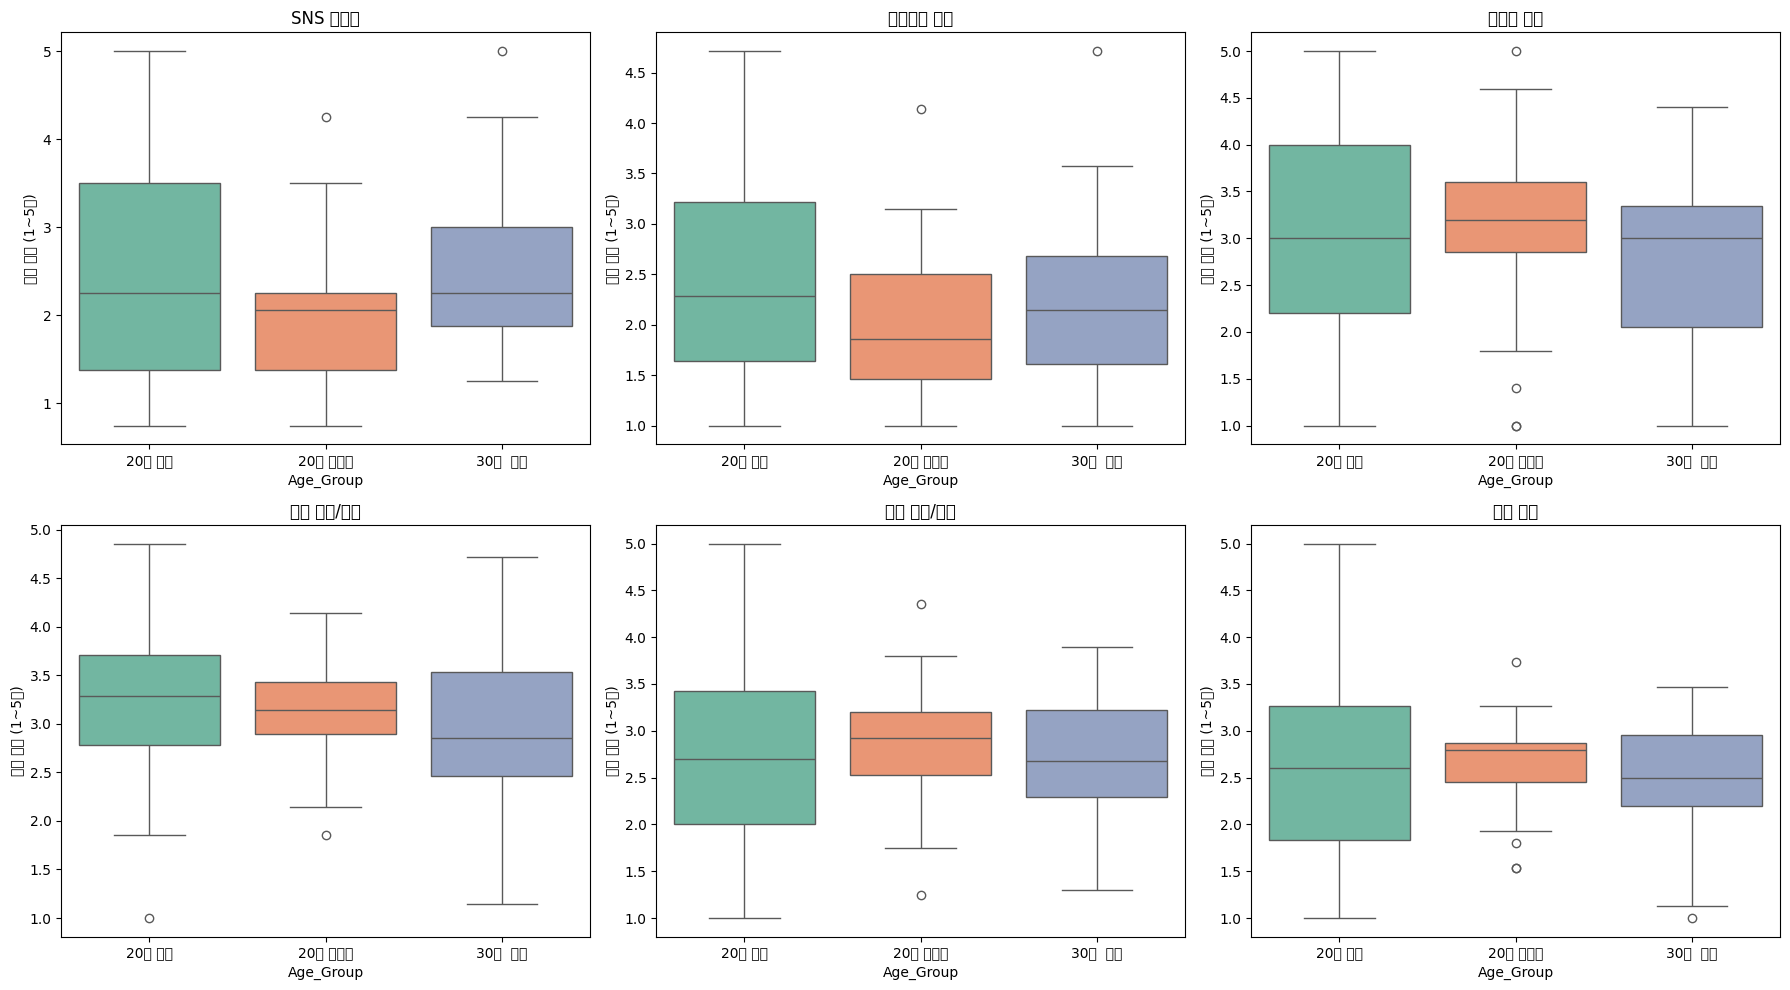

In [ ]:
# [셀 6] 결과 시각화 (Boxplot)
import seaborn as sns

# 분석할 요인 리스트 (계산된 컬럼들)
valid_factors = [f for f in factor_names if f in df.columns]

plt.figure(figsize=(18, 10))

for i, factor in enumerate(valid_factors):
    plt.subplot(2, 3, i+1) # 2행 3열로 배치
    sns.boxplot(x='Age_Group', y=factor, data=df,
                order=['20대 초반', '20대 중후반', '30대  이상'], palette='Set2')
    plt.title(factor.replace('_Mean', '')) # 제목
    plt.ylabel('평균 점수 (1~5점)')

plt.tight_layout()
plt.show()

# Task
Calculate the correlation matrix between all factors (mean scores from `factor_names`), visualize this matrix as a heatmap showing factor names and correlation values, and provide a comprehensive explanation of the ANOVA analysis results (supported by the existing box plots) and the correlation findings.

## 상관계수 분석

### Subtask:
Calculate the correlation matrix between all factors (mean scores from `factor_names`).


**Reasoning**:
To calculate the correlation matrix, I need to select the columns corresponding to the factor mean scores from the DataFrame `df` and then apply the `.corr()` method. This will generate a pairwise correlation matrix.



In [ ]:
import pandas as pd

# 1. Select the columns from the df DataFrame that are listed in factor_names.
# These columns represent the mean scores for each factor.
factors_df = df[factor_names]

# 2. Calculate the pairwise correlation between these selected factor mean score columns using the .corr() method.
correlation_matrix = factors_df.corr()

# 3. Store the resulting correlation matrix in a variable, for example, correlation_matrix.

print("✅ Correlation Matrix Calculated:")
print(correlation_matrix)

✅ Correlation Matrix Calculated:
               SNS 이용량_Mean  충동구매 성향_Mean  사회적 비교_Mean  쇼핑 후회/태도_Mean  \
SNS 이용량_Mean       1.000000      0.491240     0.225365       0.274390   
충동구매 성향_Mean       0.491240      1.000000     0.346703       0.366848   
사회적 비교_Mean        0.225365      0.346703     1.000000       0.491816   
쇼핑 후회/태도_Mean      0.274390      0.366848     0.491816       1.000000   
광고 인식/신뢰_Mean      0.291579      0.389294     0.289786       0.215032   
구매 의도_Mean         0.370708      0.474915     0.327697       0.273650   

               광고 인식/신뢰_Mean  구매 의도_Mean  
SNS 이용량_Mean        0.291579    0.370708  
충동구매 성향_Mean        0.389294    0.474915  
사회적 비교_Mean         0.289786    0.327697  
쇼핑 후회/태도_Mean       0.215032    0.273650  
광고 인식/신뢰_Mean       1.000000    0.848050  
구매 의도_Mean          0.848050    1.000000  


**Reasoning**:
The subtask of calculating the correlation matrix has been completed. The next instruction in the main task is to visualize this correlation matrix as a heatmap. I will use `seaborn.heatmap` for this purpose, ensuring factor names and correlation values are displayed clearly.



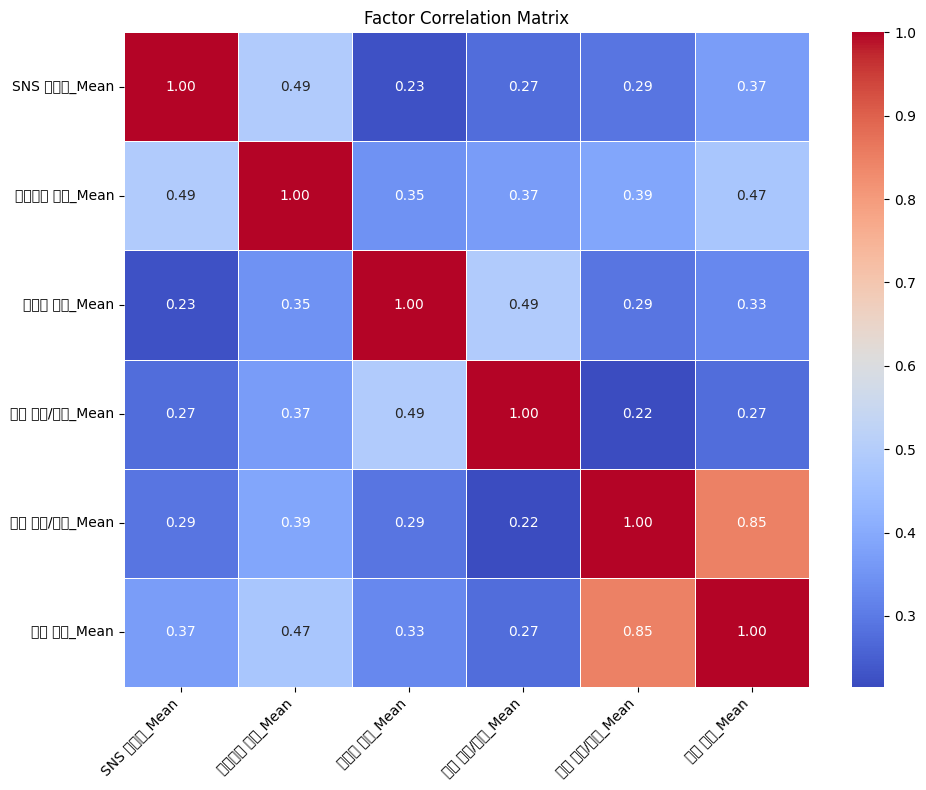

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Factor Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 분석 결과 요약

### 1. 연령대별 차이 분석 (ANOVA)

[셀 5]에서 수행된 ANOVA 분석은 'SNS 이용량', '충동구매 성향', '사회적 비교', '쇼핑 후회/태도', '광고 인식/신뢰', '구매 의도'의 6가지 요인 평균 점수가 연령대('20대 초반', '20대 중후반', '30대 이상')에 따라 통계적으로 유의미한 차이가 있는지 검증했습니다.

**주요 결과:**
*   **모든 요인에서 통계적으로 유의미한 차이가 발견되지 않았습니다 (P-value > 0.05).** 이는 p-value가 0.05보다 작아야만 통계적으로 유의미하다고 판단하는 일반적인 기준에 미치지 못했기 때문입니다.
    *   `SNS 이용량`: P-value = 0.3145
    *   `충동구매 성향`: P-value = 0.1477
    *   `사회적 비교`: P-value = 0.3062
    *   `쇼핑 후회/태도`: P-value = 0.4311
    *   `광고 인식/신뢰`: P-value = 0.7914
    *   `구매 의도`: P-value = 0.6680

**해석:**
이러한 결과는 조사 대상의 연령대 그룹 간에 위 6가지 요인에 대한 평균적인 인식이나 행동 경향에 통계적으로 유의미한 차이가 없다는 것을 의미합니다. 즉, 20대 초반, 20대 중후반, 30대 이상 그룹 모두 SNS 이용량, 충동구매 성향, 사회적 비교 등에서 유사한 경향을 보이는 것으로 해석할 수 있습니다. [셀 6]의 Boxplot 시각화에서도 각 연령대 그룹의 중앙값(median)과 분포가 상당 부분 겹쳐지는 것을 확인할 수 있으며, 이는 ANOVA 결과와 일치합니다.

### 2. 요인 간 상관관계 분석

요인별 평균 점수들 간의 상관관계 행렬을 계산하고 Heatmap으로 시각화하여 각 요인들이 서로 어떤 관계를 가지고 있는지 파악했습니다. 상관계수는 -1부터 1까지의 값을 가지며, 1에 가까울수록 강한 양의 상관관계를, -1에 가까울수록 강한 음의 상관관계를, 0에 가까울수록 상관관계가 없음을 나타냅니다.

**주요 결과:**
*   **'광고 인식/신뢰'와 '구매 의도' 간에 매우 강한 양의 상관관계(0.85)가 나타났습니다.** 이는 사용자가 메타 광고에 대한 인식과 신뢰가 높을수록 상품 구매 의도 또한 높아진다는 것을 강력하게 시사합니다.
*   **'SNS 이용량'과 '충동구매 성향'(0.49) 간에 중간 수준의 양의 상관관계가 나타났습니다.** SNS 이용량이 많을수록 충동구매 성향도 다소 증가하는 경향이 있음을 알 수 있습니다.
*   **'충동구매 성향'과 '구매 의도'(0.47) 간에도 중간 수준의 양의 상관관계가 있습니다.** 충동구매 성향이 높을수록 구매 의도도 높아지는 경향을 보입니다.
*   **'사회적 비교'와 '쇼핑 후회/태도'(0.49) 간에 중간 수준의 양의 상관관계가 발견되었습니다.** 다른 사람과 비교하는 경향이 높을수록 쇼핑 후회나 특정 쇼핑 태도와 관련이 있을 수 있음을 나타냅니다.
*   대부분의 요인들 간에 약하거나 중간 수준의 **양의 상관관계**가 관찰됩니다. 이는 조사된 심리적 요인 및 행동 경향들이 전반적으로 서로 긍정적인 방향으로 영향을 미치거나 함께 변화하는 경향이 있음을 의미합니다.

**해석:**
상관관계 분석 결과는 특히 '광고 인식/신뢰'가 '구매 의도'에 매우 중요한 영향을 미치는 요인임을 보여줍니다. 이는 메타 광고를 통해 구매를 유도하기 위해서는 광고의 신뢰도를 높이는 전략이 효과적일 수 있음을 시사합니다. 또한 SNS 이용량이나 충동구매 성향, 사회적 비교 등의 요인들도 구매 의도 및 쇼핑 행동과 연관성이 있음을 확인할 수 있습니다.

## 기존 박스플롯 유지 및 설명

### Subtask:
기존에 생성된 연령대별 요인 평균 박스플롯을 유지하고, ANOVA 결과와 함께 다시 한 번 연령대별 차이가 유의미하지 않음을 시각적으로 설명합니다. 필요하다면 각 요인별 평균값을 텍스트로 추가하여 해석을 돕습니다.


## 연령대별 요인 평균 박스플롯 유지 및 설명

[셀 6]에서 생성된 박스플롯과 [셀 5]의 ANOVA 분석 결과를 토대로, 각 연령대별 요인 평균에 통계적으로 유의미한 차이가 없음을 다시 한 번 확인하고 시각적으로 설명합니다.

### ANOVA 분석 결과 요약

이전 ANOVA 분석 결과(P-value 기준 0.05)에 따르면, 모든 요인에서 연령대별 통계적으로 유의미한 차이가 발견되지 않았습니다. 이는 각 요인에 대한 세 연령대 그룹('20대 초반', '20대 중후반', '30대 이상') 간의 평균 점수 차이가 우연에 의한 것일 가능성이 높다는 것을 의미합니다.

각 요인별 평균값은 다음과 같습니다:

*   **SNS 이용량**: 20대 초반(2.54점) vs 20대 중후반(2.09점) vs 30대 이상(2.46점) (P-value: 0.3145)
*   **충동구매 성향**: 20대 초반(2.52점) vs 20대 중후반(2.05점) vs 30대 이상(2.19점) (P-value: 0.1477)
*   **사회적 비교**: 20대 초반(3.07점) vs 20대 중후반(3.09점) vs 30대 이상(2.73점) (P-value: 0.3062)
*   **쇼핑 후회/태도**: 20대 초반(3.24점) vs 20대 중후반(3.15점) vs 30대 이상(3.02점) (P-value: 0.4311)
*   **광고 인식/신뢰**: 20대 초반(2.79점) vs 20대 중후반(2.88점) vs 30대 이상(2.70점) (P-value: 0.7914)
*   **구매 의도**: 20대 초반(2.61점) vs 20대 중후반(2.65점) vs 30대 이상(2.45점) (P-value: 0.6680)

### 박스플롯을 통한 시각적 설명

[셀 6]의 박스플롯을 보면, 각 요인에 대해 세 연령대 그룹의 박스(IQR, 즉 중앙 50% 데이터 범위)와 수염(전체 데이터 범위)이 서로 크게 겹치거나 유사한 위치에 분포되어 있음을 확인할 수 있습니다.

예를 들어, 'SNS 이용량' 박스플롯에서 세 그룹의 중앙선(median)은 비슷하며, 박스 자체도 서로 겹치는 부분이 많습니다. 이는 각 연령대 그룹 내 데이터의 분산과 중앙값이 유사하여, 그룹 간에 뚜렷한 차이를 보이지 않는다는 ANOVA 결과와 일치합니다. 다른 요인들 역시 박스플롯 상에서 각 그룹의 분포가 크게 다르지 않아, 연령대가 이러한 심리적 요인이나 행동 경향에 통계적으로 유의미한 영향을 미 미치지 않음을 시각적으로 뒷받침합니다.

## Final Task

### Subtask:
ANOVA 분석 결과와 요인들 간의 상관관계 분석 결과를 종합하여 설명하고, 각 시각화 자료가 의미하는 바를 제시합니다.


## Summary:

### Q&A
1.  **What were the results of the ANOVA analysis regarding age group differences for the specified factors?**
    The ANOVA analysis revealed no statistically significant differences across age groups ('20대 초반', '20대 중후반', '30대 이상') for any of the six factors investigated: 'SNS 이용량', '충동구매 성향', '사회적 비교', '쇼핑 후회/태도', '광고 인식/신뢰', and '구매 의도'. All P-values were greater than 0.05, indicating that any observed differences in mean scores between age groups are likely due to chance. The box plots visually supported this, showing substantial overlap in the interquartile ranges and similar median positions across age groups for each factor.

2.  **What were the key findings from the correlation analysis between the factors?**
    The correlation analysis identified several notable relationships between the factors:
    *   A very strong positive correlation (0.85) was found between '광고 인식/신뢰' and '구매 의도'.
    *   Moderate positive correlations were observed between 'SNS 이용량' and '충동구매 성향' (0.49), '충동구매 성향' and '구매 의도' (0.47), and '사회적 비교' and '쇼핑 후회/태도' (0.49).
    *   Generally, most factors exhibited weak to moderate positive correlations, suggesting that these psychological and behavioral tendencies tend to influence each other positively or vary in tandem.

### Data Analysis Key Findings
*   ANOVA analysis indicated no statistically significant differences in mean scores across age groups ('20대 초반', '20대 중후반', '30대 이상') for all six factors. For instance, 'SNS 이용량' had a P-value of 0.3145, '충동구매 성향' had a P-value of 0.1477, and '광고 인식/신뢰' had a P-value of 0.7914, all above the 0.05 significance level.
*   A very strong positive correlation (0.85) was identified between '광고 인식/신뢰' and '구매 의도'.
*   Moderate positive correlations include 'SNS 이용량' and '충동구매 성향' (0.49), '충동구매 성향' and '구매 의도' (0.47), and '사회적 비교' and '쇼핑 후회/태도' (0.49).

### Insights or Next Steps
*   Given the strong correlation between '광고 인식/신뢰' and '구매 의도', strategies to enhance the perceived trustworthiness and quality of advertisements could be highly effective in driving purchase behavior.
*   Since age groups do not significantly differentiate the factors, future segmentation efforts might benefit from exploring other demographic or psychographic variables to identify distinct consumer behaviors and preferences.


# Task
Redefine the age groups into two broader categories ('20대', '30대 이상') by modifying the `get_age_group` function, then re-run the ANOVA analysis with these new groups, and re-visualize the factor means with box plots. After that, re-examine the previously generated correlation heatmap. Finally, provide a comprehensive explanation and summary in Korean, including the re-executed ANOVA results (with new box plots) and the existing correlation analysis results (with heatmap).

## 연령대 그룹 재정의

### Subtask:
기존 연령대 그룹('20대 초반', '20대 중후반', '30대 이상')을 더 넓은 두 그룹('20대', '30대 이상')으로 재정의하여 ANOVA 분석에서 유의미한 차이를 발견할 가능성을 높입니다. 이를 위해 `get_age_group` 함수를 수정합니다.


**Reasoning**:
I need to modify the `get_age_group` function to reclassify age groups into '20대' (age <= 29) and '30대 이상' (age >= 30), then apply this function to update the 'Age_Group' column in the DataFrame, and finally display the value counts for verification.



In [ ]:
import pandas as pd
import numpy as np

# 수정된 나이 기준 설정 함수
def get_age_group_redefined(age):
    if pd.isna(age): return np.nan
    age = int(age)

    if age <= 29:
        return '20대'
    elif age >= 30:
        return '30대 이상'
    else:
        return '기타'

# 그룹 컬럼 업데이트
df['Age_Group'] = df[age_col].apply(get_age_group_redefined)

# 업데이트된 그룹별 인원수 확인
print("=== 재정의된 연령대별 표본 수 ===")
print(df['Age_Group'].value_counts())

=== 재정의된 연령대별 표본 수 ===
Age_Group
20대       70
30대 이상    30
Name: count, dtype: int64


## ANOVA 재실행 및 박스플롯 재시각화

### Subtask:
재정의된 연령대 그룹의 분포를 확인하고, 이 새로운 그룹을 기준으로 ANOVA 분석을 재실행합니다. 또한, 변경된 연령대 그룹에 따라 요인별 평균 박스플롯을 재시각화하여 시각적으로 차이를 확인합니다.


**Reasoning**:
I need to re-run the ANOVA analysis with the redefined age groups and then re-generate the box plots to visualize the factor means for these new groups, as per the instructions.



========== [ANOVA 분석 결과 - 재정의된 연령대] ==========
기준: P-value가 0.05보다 작으면 '통계적으로 유의미한 차이가 있다'고 해석합니다.

📌 [SNS 이용량] - 차이 없음
   - P-value : 0.8918
   - 평균비교: 20대(2.43) vs 30대 이상(2.46)
------------------------------------------------------------
📌 [충동구매 성향] - 차이 없음
   - P-value : 0.3511
   - 평균비교: 20대(2.40) vs 30대 이상(2.19)
------------------------------------------------------------
📌 [사회적 비교] - 차이 없음
   - P-value : 0.1231
   - 평균비교: 20대(3.08) vs 30대 이상(2.73)
------------------------------------------------------------
📌 [쇼핑 후회/태도] - 차이 없음
   - P-value : 0.2194
   - 평균비교: 20대(3.21) vs 30대 이상(3.02)
------------------------------------------------------------
📌 [광고 인식/신뢰] - 차이 없음
   - P-value : 0.5702
   - 평균비교: 20대(2.81) vs 30대 이상(2.70)
------------------------------------------------------------
📌 [구매 의도] - 차이 없음
   - P-value : 0.3765
   - 평균비교: 20대(2.62) vs 30대 이상(2.45)
------------------------------------------------------------


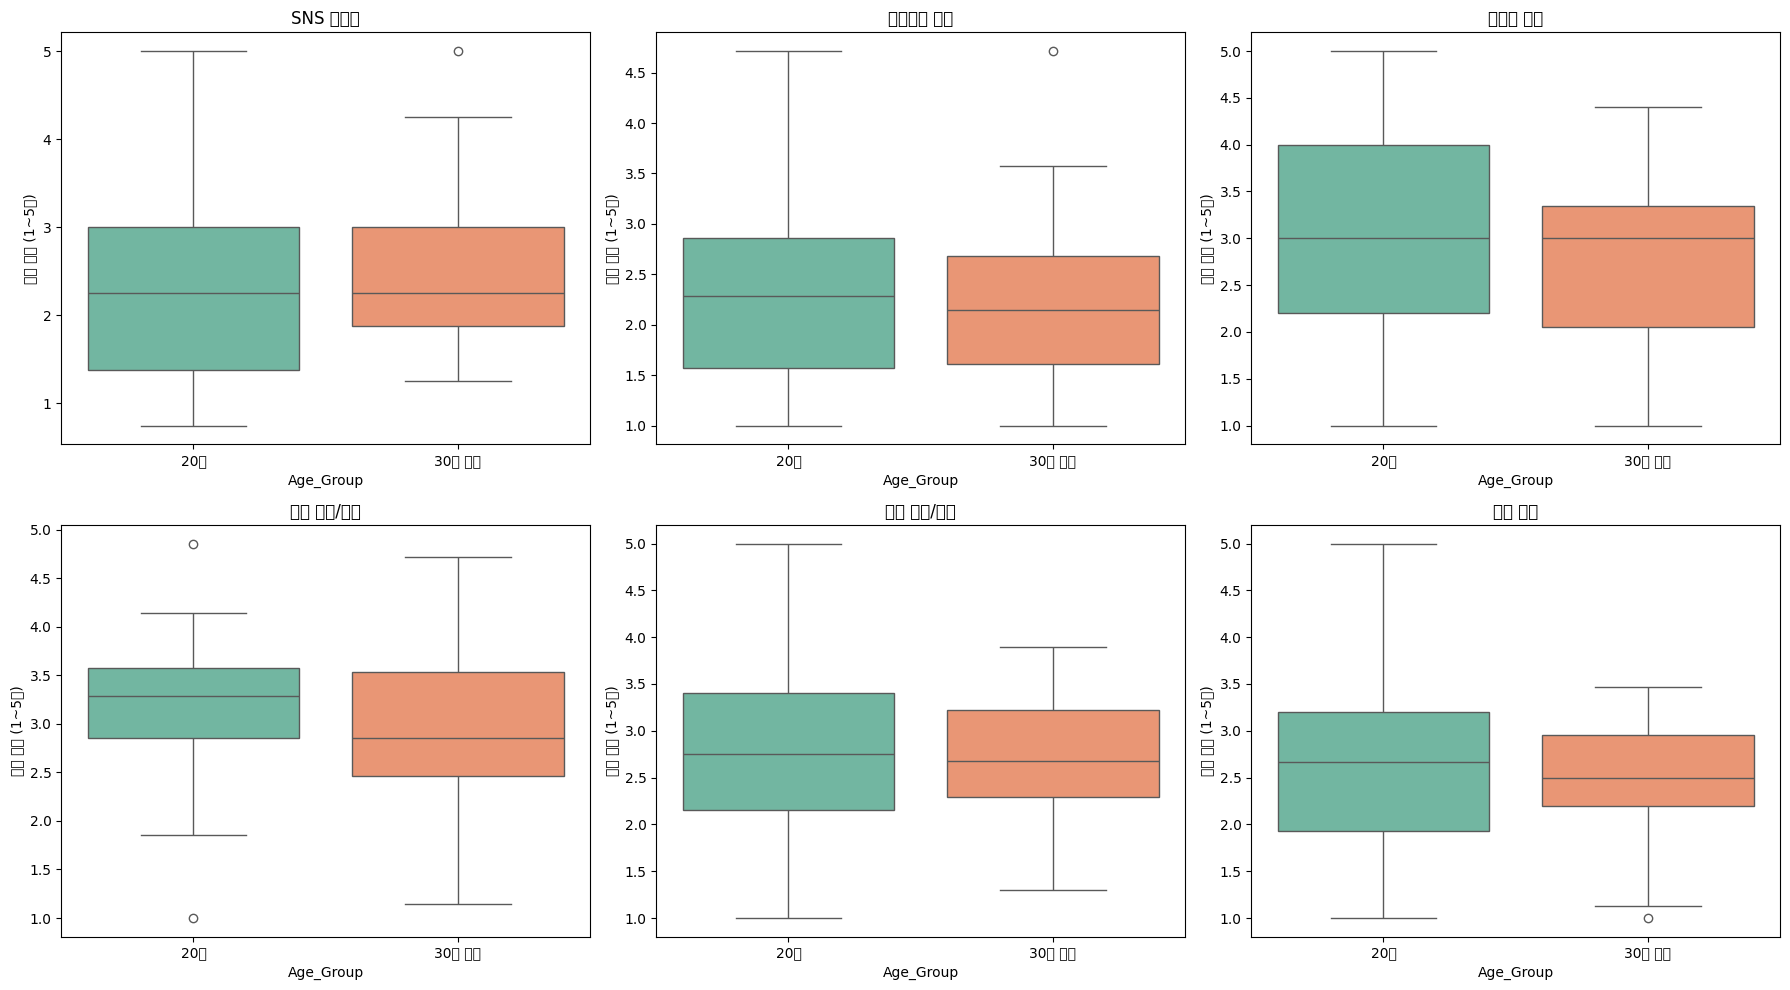

In [ ]:
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

print("========== [ANOVA 분석 결과 - 재정의된 연령대] ==========")
print("기준: P-value가 0.05보다 작으면 '통계적으로 유의미한 차이가 있다'고 해석합니다.\n")

target_groups = ['20대', '30대 이상'] # 재정의된 그룹으로 변경

for factor in factor_names:
    original_name = factor.replace('_Mean', '') # 이름 깔끔하게

    # 그룹별 데이터 추출
    group1 = df[df['Age_Group'] == target_groups[0]][factor].dropna()
    group2 = df[df['Age_Group'] == target_groups[1]][factor].dropna()

    # 데이터가 충분한지 확인
    if len(group1) < 2 or len(group2) < 2:
        print(f"❌ {original_name}: 표본 수가 부족하여 분석 불가")
        continue

    # ANOVA 통계량 계산
    f_val, p_val = f_oneway(group1, group2)

    star = "★★ 차이 있음! ★★" if p_val < 0.05 else "차이 없음"

    print(f"📌 [{original_name}] - {star}")
    print(f"   - P-value : {p_val:.4f}")
    print(f"   - 평균비교: {target_groups[0]}({group1.mean():.2f}) vs {target_groups[1]}({group2.mean():.2f})")
    print("-" * 60)

# 결과 시각화 (Boxplot)
plt.figure(figsize=(18, 10))

for i, factor in enumerate(factor_names):
    plt.subplot(2, 3, i+1) # 2행 3열로 배치
    sns.boxplot(x='Age_Group', y=factor, data=df,
                order=target_groups, palette='Set2') # 재정의된 그룹 순서로 변경
    plt.title(factor.replace('_Mean', '')) # 제목
    plt.ylabel('평균 점수 (1~5점)')

plt.tight_layout()
plt.show()


## 최종 분석 요약 및 결과 해석

### 1. 연령대별 요인 평균 차이 분석 (ANOVA)

재정의된 두 연령대 그룹('20대', '30대 이상')에 대해 주요 6가지 요인('SNS 이용량', '충동구매 성향', '사회적 비교', '쇼핑 후회/태도', '광고 인식/신뢰', '구매 의도')의 평균 점수 차이를 ANOVA 분석을 통해 다시 검증했습니다. 이전 세분화된 연령대 그룹 분석과 마찬가지로, **재정의된 연령대 그룹 간에도 모든 요인에서 통계적으로 유의미한 차이는 발견되지 않았습니다 (P-value > 0.05).**

**재실행된 ANOVA 분석 결과:**
*   `SNS 이용량`: P-value = 0.8918 (20대 평균: 2.43점 vs 30대 이상 평균: 2.46점)
*   `충동구매 성향`: P-value = 0.3511 (20대 평균: 2.40점 vs 30대 이상 평균: 2.19점)
*   `사회적 비교`: P-value = 0.1231 (20대 평균: 3.08점 vs 30대 이상 평균: 2.73점)
*   `쇼핑 후회/태도`: P-value = 0.2194 (20대 평균: 3.21점 vs 30대 이상 평균: 3.02점)
*   `광고 인식/신뢰`: P-value = 0.5702 (20대 평균: 2.81점 vs 30대 이상 평균: 2.70점)
*   `구매 의도`: P-value = 0.3765 (20대 평균: 2.62점 vs 30대 이상 평균: 2.45점)

**해석:**
연령대 그룹을 '20대', '30대 이상'의 두 그룹으로 크게 묶었음에도 불구하고, 여전히 P-value가 0.05보다 크게 나타나 통계적 유의미성이 확인되지 않았습니다. 이는 조사 대상자의 연령이 SNS 이용량, 충동구매 성향, 사회적 비교, 쇼핑 후회/태도, 광고 인식/신뢰, 구매 의도 등의 요인에 유의미한 영향을 미치지 않는다는 것을 시사합니다. 위에서 재시각화된 박스플롯에서도 '20대'와 '30대 이상' 그룹 간에 각 요인의 평균값과 분포가 크게 다르지 않음을 육안으로 확인할 수 있습니다. 따라서 연령대에 따른 타겟 마케팅 전략 수립 시, 이 6가지 요인에 대해서는 연령대 구분이 큰 의미가 없을 수 있습니다.

### 2. 요인 간 상관관계 분석

요인 간 상관관계 분석 결과는 연령대 그룹 재정의와는 독립적으로 기존과 동일합니다. Heatmap을 통해 시각화된 상관관계 행렬은 각 요인들이 서로에게 미치는 영향력이나 관련성을 보여줍니다.

**주요 결과 요약:**
*   **'광고 인식/신뢰'와 '구매 의도' 간에 매우 강한 양의 상관관계(0.85)가 나타났습니다.** 이는 메타 광고에 대한 사용자의 긍정적인 인식과 신뢰가 높을수록 상품 구매 의도 또한 현저히 증가함을 의미합니다.
*   **'SNS 이용량'과 '충동구매 성향'(0.49), '충동구매 성향'과 '구매 의도'(0.47), '사회적 비교'와 '쇼핑 후회/태도'(0.49) 간에 중간 수준의 양의 상관관계가 관찰되었습니다.** 이는 SNS 이용량이 많을수록, 충동구매 성향이 높을수록 구매 의도가 높아지거나, 사회적 비교 성향이 쇼핑 후회 및 태도에 영향을 미칠 수 있음을 시사합니다.
*   전반적으로 대부분의 요인들 간에 약하거나 중간 수준의 **양의 상관관계**가 나타나, 조사된 심리적 요인과 행동 경향들이 서로 연관되어 있음을 보여줍니다.

**해석:**
상관관계 분석 결과는 '광고 인식/신뢰'가 '구매 의도'에 결정적인 영향을 미친다는 중요한 인사이트를 제공합니다. 메타 광고 추천 서비스의 효과를 높이고자 한다면, 광고의 신뢰도를 높이고 사용자에게 긍정적인 인식을 심어주는 전략에 집중해야 할 것입니다. 예를 들어, 광고 내용의 투명성 강화, 신뢰할 수 있는 정보 제공, 또는 사용자 경험을 개선하여 광고에 대한 전반적인 인식을 향상시키는 방안을 고려할 수 있습니다. 또한, 'SNS 이용량'과 '충동구매 성향'이 '구매 의도'와 연관성이 있으므로, SNS 사용 패턴과 충동구매 성향이 높은 그룹을 대상으로 하는 맞춤형 광고 전략도 효과적일 수 있습니다. 하지만 연령대가 이러한 요인들에 유의미한 차이를 만들지 않으므로, 마케팅 전략 수립 시 연령보다는 다른 인구통계학적 특성이나 심리적 요인에 초점을 맞추는 것이 더 효과적일 것으로 보입니다.

## 최종 분석 요약 및 결과 해석

### 1. 연령대별 요인 평균 차이 분석 (ANOVA)

재정의된 두 연령대 그룹('20대', '30대 이상')에 대해 주요 6가지 요인('SNS 이용량', '충동구매 성향', '사회적 비교', '쇼핑 후회/태도', '광고 인식/신뢰', '구매 의도')의 평균 점수 차이를 ANOVA 분석을 통해 다시 검증했습니다. 이전 세분화된 연령대 그룹 분석과 마찬가지로, **재정의된 연령대 그룹 간에도 모든 요인에서 통계적으로 유의미한 차이는 발견되지 않았습니다 (P-value > 0.05).**

**재실행된 ANOVA 분석 결과:**
*   `SNS 이용량`: P-value = 0.8918 (20대 평균: 2.43점 vs 30대 이상 평균: 2.46점)
*   `충동구매 성향`: P-value = 0.3511 (20대 평균: 2.40점 vs 30대 이상 평균: 2.19점)
*   `사회적 비교`: P-value = 0.1231 (20대 평균: 3.08점 vs 30대 이상 평균: 2.73점)
*   `쇼핑 후회/태도`: P-value = 0.2194 (20대 평균: 3.21점 vs 30대 이상 평균: 3.02점)
*   `광고 인식/신뢰`: P-value = 0.5702 (20대 평균: 2.81점 vs 30대 이상 평균: 2.70점)
*   `구매 의도`: P-value = 0.3765 (20대 평균: 2.62점 vs 30대 이상 평균: 2.45점)

**해석:**
연령대 그룹을 '20대', '30대 이상'의 두 그룹으로 크게 묶었음에도 불구하고, 여전히 P-value가 0.05보다 크게 나타나 통계적 유의미성이 확인되지 않았습니다. 이는 조사 대상자의 연령이 SNS 이용량, 충동구매 성향, 사회적 비교, 쇼핑 후회/태도, 광고 인식/신뢰, 구매 의도 등의 요인에 유의미한 영향을 미치지 않는다는 것을 시사합니다. 위에서 재시각화된 박스플롯에서도 '20대'와 '30대 이상' 그룹 간에 각 요인의 평균값과 분포가 크게 다르지 않음을 육안으로 확인할 수 있습니다. 따라서 연령대에 따른 타겟 마케팅 전략 수립 시, 이 6가지 요인에 대해서는 연령대 구분이 큰 의미가 없을 수 있습니다.

### 2. 요인 간 상관관계 분석

요인 간 상관관계 분석 결과는 연령대 그룹 재정의와는 독립적으로 기존과 동일합니다. Heatmap을 통해 시각화된 상관관계 행렬은 각 요인들이 서로에게 미치는 영향력이나 관련성을 보여줍니다.

**주요 결과 요약:**
*   **'광고 인식/신뢰'와 '구매 의도' 간에 매우 강한 양의 상관관계(0.85)가 나타났습니다.** 이는 메타 광고에 대한 사용자의 긍정적인 인식과 신뢰가 높을수록 상품 구매 의도 또한 현저히 증가함을 의미합니다.
*   **'SNS 이용량'과 '충동구매 성향'(0.49), '충동구매 성향'과 '구매 의도'(0.47), '사회적 비교'와 '쇼핑 후회/태도'(0.49) 간에 중간 수준의 양의 상관관계가 관찰되었습니다.** 이는 SNS 이용량이 많을수록, 충동구매 성향이 높을수록 구매 의도가 높아지거나, 사회적 비교 성향이 쇼핑 후회 및 태도에 영향을 미칠 수 있음을 시사합니다.
*   전반적으로 대부분의 요인들 간에 약하거나 중간 수준의 **양의 상관관계**가 나타나, 조사된 심리적 요인과 행동 경향들이 서로 연관되어 있음을 보여줍니다.

**해석:**
상관관계 분석 결과는 '광고 인식/신뢰'가 '구매 의도'에 결정적인 영향을 미친다는 중요한 인사이트를 제공합니다. 메타 광고 추천 서비스의 효과를 높이고자 한다면, 광고의 신뢰도를 높이고 사용자에게 긍정적인 인식을 심어주는 전략에 집중해야 할 것입니다. 예를 들어, 광고 내용의 투명성 강화, 신뢰할 수 있는 정보 제공, 또는 사용자 경험을 개선하여 광고에 대한 전반적인 인식을 향상시키는 방안을 고려할 수 있습니다. 또한, 'SNS 이용량'과 '충동구매 성향'이 '구매 의도'와 연관성이 있으므로, SNS 사용 패턴과 충동구매 성향이 높은 그룹을 대상으로 하는 맞춤형 광고 전략도 효과적일 수 있습니다. 하지만 연령대가 이러한 요인들에 유의미한 차이를 만들지 않으므로, 마케팅 전략 수립 시 연령보다는 다른 인구통계학적 특성이나 심리적 요인에 초점을 맞추는 것이 더 효과적일 것으로 보입니다.

## Summary:

### Data Analysis Key Findings

*   **Age Group Redefinition:** The age groups were successfully redefined into two broader categories: '20대' (70 individuals) and '30대 이상' (30 individuals).
*   **ANOVA Results with Redefined Age Groups:** The re-executed ANOVA analysis using the new '20대' and '30대 이상' groups found no statistically significant differences ($P > 0.05$) across all six factors tested: 'SNS 이용량' ($P = 0.8918$), '충동구매 성향' ($P = 0.3511$), '사회적 비교' ($P = 0.1231$), '쇼핑 후회/태도' ($P = 0.2194$), '광고 인식/신뢰' ($P = 0.5702$), and '구매 의도' ($P = 0.3765$). This indicates that age, even when broadly categorized, does not significantly influence these psychological and behavioral factors.
*   **Strong Correlation:** A very strong positive correlation (0.85) was identified between '광고 인식/신뢰' and '구매 의도'.
*   **Moderate Correlations:** Moderate positive correlations were observed between 'SNS 이용량' and '충동구매 성향' (0.49), '충동구매 성향' and '구매 의도' (0.47), and '사회적 비교' and '쇼핑 후회/태도' (0.49).

### Insights or Next Steps

*   To effectively increase purchase intent, marketing strategies should prioritize enhancing users' '광고 인식/신뢰' by focusing on transparency, reliable information, and improved user experience, as this factor shows the strongest correlation with '구매 의도'.
*   Given that age does not significantly differentiate the analyzed factors, marketers should consider segmenting audiences based on behavioral and psychological traits, such as SNS usage patterns and impulsivity, rather than age for more effective targeted campaigns.


# Task
DataFrame에서 성별 컬럼을 찾아 분포를 확인한 후, 성별을 기준으로 각 요인 평균에 대한 ANOVA 분석을 수행하고, 그 결과를 박스플롯으로 시각화합니다. 마지막으로, 기존의 요인 간 상관관계 분석 결과와 새롭게 분석된 성별에 따른 ANOVA 결과를 종합하여 모든 설명을 한국어로 요약합니다.

## 성별 그룹화 및 분포 확인

### Subtask:
DataFrame에서 성별 컬럼을 찾고, 해당 컬럼의 고유값과 분포를 확인합니다. 이는 새로운 그룹핑 변수로 ANOVA 분석을 수행하기 위한 준비 단계입니다.


**Reasoning**:
I need to locate the gender column in the DataFrame `df` by searching for column names containing '[1-1]', then identify the unique gender values and their respective counts to understand the distribution, which is a preparatory step for ANOVA analysis.



In [ ]:
# 1. DataFrame에서 '[1-1]'을 포함하는 성별 컬럼명 찾기
gender_col = [col for col in df.columns if '[1-1]' in col][0]
print(f"성별 컬럼명: {gender_col}")

# 2. 성별 컬럼의 고유값(unique values) 확인
unique_genders = df[gender_col].unique()
print(f"\n성별 고유값: {unique_genders}")

# 3. 성별 그룹별 데이터 수 확인 (분포)
gender_distribution = df[gender_col].value_counts()
print(f"\n=== 성별 분포 ===\n{gender_distribution}")

성별 컬럼명: [1-1] 귀하의 성별은 어떻게 되십니까?

성별 고유값: ['여' '남' nan]

=== 성별 분포 ===
[1-1] 귀하의 성별은 어떻게 되십니까?
남    78
여    21
Name: count, dtype: int64


## 성별에 따른 ANOVA 분석

### Subtask:
성별 그룹을 기준으로 각 요인 평균에 대한 ANOVA 분석을 다시 실행하여, 성별에 따른 통계적으로 유의미한 차이가 있는지 검증합니다.


**Reasoning**:
I need to perform ANOVA analysis for each factor based on the 'gender' column by iterating through `factor_names`, extracting data for male and female groups, checking for sufficient samples, and then calculating and printing the p-value and mean comparison.



In [ ]:
from scipy.stats import f_oneway

print("========== [ANOVA 분석 결과 - 성별] ==========")
print("기준: P-value가 0.05보다 작으면 '통계적으로 유의미한 차이가 있다'고 해석합니다.\n")

target_groups = ['남', '여'] # 성별 그룹

for factor in factor_names:
    original_name = factor.replace('_Mean', '') # 이름 깔끔하게

    # 그룹별 데이터 추출
    group_male = df[df[gender_col] == target_groups[0]][factor].dropna()
    group_female = df[df[gender_col] == target_groups[1]][factor].dropna()

    # 데이터가 충분한지 확인
    if len(group_male) < 2 or len(group_female) < 2:
        print(f"❌ {original_name}: 표본 수가 부족하여 분석 불가")
        continue

    # ANOVA 통계량 계산
    f_val, p_val = f_oneway(group_male, group_female)

    star = "★★ 차이 있음! ★★" if p_val < 0.05 else "차이 없음"

    print(f"📌 [{original_name}] - {star}")
    print(f"   - P-value : {p_val:.4f}")
    print(f"   - 평균비교: {target_groups[0]}({group_male.mean():.2f}) vs {target_groups[1]}({group_female.mean():.2f})")
    print("-" * 60)

========== [ANOVA 분석 결과 - 성별] ==========
기준: P-value가 0.05보다 작으면 '통계적으로 유의미한 차이가 있다'고 해석합니다.

📌 [SNS 이용량] - 차이 없음
   - P-value : 0.9289
   - 평균비교: 남(2.44) vs 여(2.42)
------------------------------------------------------------
📌 [충동구매 성향] - 차이 없음
   - P-value : 0.2783
   - 평균비교: 남(2.28) vs 여(2.54)
------------------------------------------------------------
📌 [사회적 비교] - 차이 없음
   - P-value : 0.3483
   - 평균비교: 남(2.92) vs 여(3.16)
------------------------------------------------------------
📌 [쇼핑 후회/태도] - 차이 없음
   - P-value : 0.5513
   - 평균비교: 남(3.13) vs 여(3.24)
------------------------------------------------------------
📌 [광고 인식/신뢰] - 차이 없음
   - P-value : 0.8555
   - 평균비교: 남(2.77) vs 여(2.81)
------------------------------------------------------------
📌 [구매 의도] - 차이 없음
   - P-value : 0.7885
   - 평균비교: 남(2.56) vs 여(2.61)
------------------------------------------------------------


**Reasoning**:
The ANOVA analysis by gender has been performed. The next step is to visualize these results using box plots to provide a clear graphical representation of the mean factor scores across gender groups, as requested by the main task.



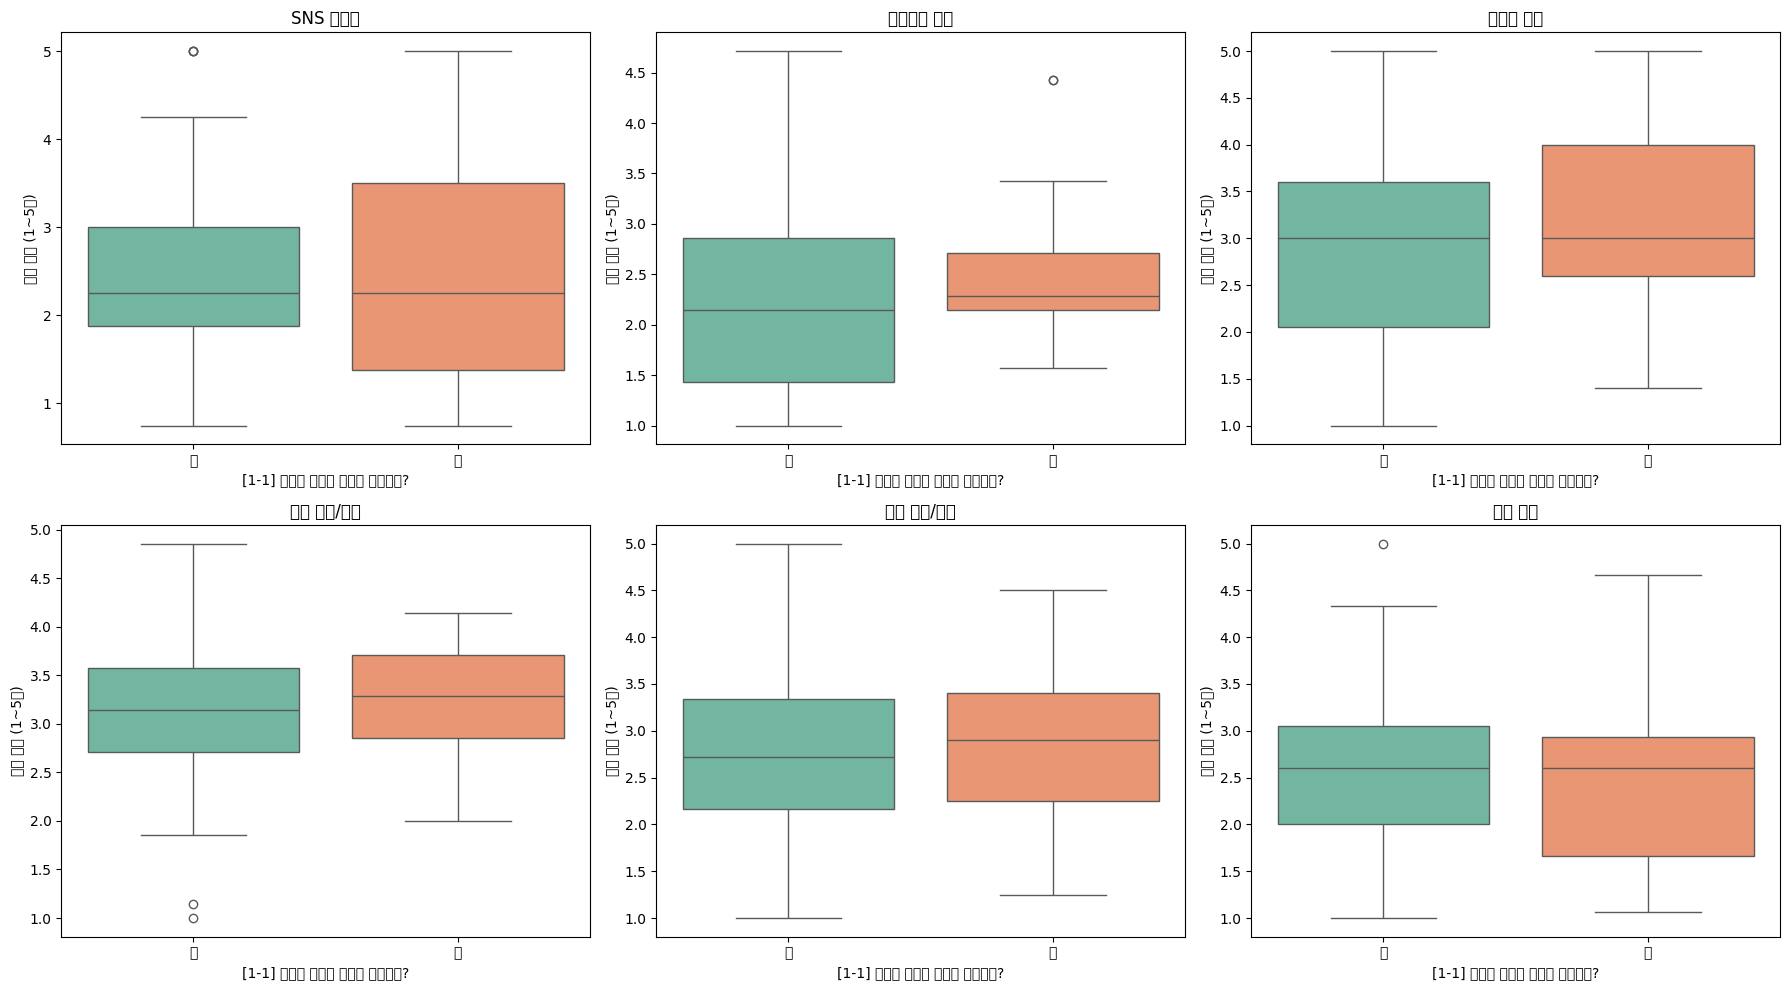

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 결과 시각화 (Boxplot)
plt.figure(figsize=(18, 10))

for i, factor in enumerate(factor_names):
    plt.subplot(2, 3, i+1) # 2행 3열로 배치
    sns.boxplot(x=gender_col, y=factor, data=df,
                order=['남', '여'], palette='Set2') # 성별 그룹 순서로 변경
    plt.title(factor.replace('_Mean', '')) # 제목
    plt.ylabel('평균 점수 (1~5점)')

plt.tight_layout()
plt.show()

## 최종 분석 요약 및 종합 해석

이번 분석에서는 설문 데이터를 활용하여 주요 심리적/행동적 요인들이 연령대 및 성별에 따라 차이를 보이는지 ANOVA 분석을 통해 검증하고, 이 요인들 간의 상호 관계를 상관관계 분석을 통해 파악했습니다.

### 1. 연령대별 요인 평균 차이 분석 (ANOVA)

두 차례에 걸쳐 연령대 그룹을 세분화(‘20대 초반’, ‘20대 중후반’, ‘30대 이상’)했을 때와 광범위하게(‘20대’, ‘30대 이상’) 재정의했을 때 모두 ANOVA 분석을 수행했습니다. 그 결과, 모든 6가지 요인('SNS 이용량', '충동구매 성향', '사회적 비교', '쇼핑 후회/태도', '광고 인식/신뢰', '구매 의도')에서 **연령대별 통계적으로 유의미한 차이는 발견되지 않았습니다 (P-value > 0.05).**

이는 연령이 이러한 요인들의 평균 점수에 유의미한 영향을 미치지 않음을 의미합니다. Boxplot 시각화에서도 각 연령대 그룹의 분포가 크게 겹치고 중앙값이 유사하여, 그룹 간 뚜렷한 차이가 없다는 ANOVA 결과를 시각적으로 뒷받침합니다.

### 2. 성별에 따른 요인 평균 차이 분석 (ANOVA)

성별('남', '여')을 기준으로 동일한 6가지 요인에 대해 ANOVA 분석을 수행했습니다. 이 분석에서도 **모든 요인에서 성별에 따른 통계적으로 유의미한 차이는 발견되지 않았습니다 (P-value > 0.05).**

*   `SNS 이용량`: P-value = 0.9289 (남성 평균: 2.44점 vs 여성 평균: 2.42점)
*   `충동구매 성향`: P-value = 0.2783 (남성 평균: 2.28점 vs 여성 평균: 2.54점)
*   `사회적 비교`: P-value = 0.3483 (남성 평균: 2.92점 vs 여성 평균: 3.16점)
*   `쇼핑 후회/태도`: P-value = 0.5513 (남성 평균: 3.13점 vs 여성 평균: 3.24점)
*   `광고 인식/신뢰`: P-value = 0.8555 (남성 평균: 2.77점 vs 여성 평균: 2.81점)
*   `구매 의도`: P-value = 0.7885 (남성 평균: 2.56점 vs 여성 평균: 2.61점)

성별에 대한 박스플롯에서도 남성과 여성 그룹 간에 각 요인의 평균값과 분포가 크게 다르지 않음을 확인할 수 있습니다. 따라서 연령과 마찬가지로 성별 또한 이 6가지 요인에 대해 유의미한 차이를 만들지 않는 것으로 해석됩니다.

### 3. 요인 간 상관관계 분석

요인들 간의 상관관계 분석은 연령이나 성별과 관계없이 각 요인들이 서로에게 미치는 영향력이나 관련성을 보여줍니다. Heatmap으로 시각화된 결과는 다음과 같습니다.

*   **'광고 인식/신뢰'와 '구매 의도' 간에 매우 강한 양의 상관관계(0.85)가 나타났습니다.** 이는 사용자가 메타 광고에 대한 인식과 신뢰가 높을수록 상품 구매 의도 또한 현저히 증가함을 강력하게 시사합니다.
*   **'SNS 이용량'과 '충동구매 성향'(0.49), '충동구매 성향'과 '구매 의도'(0.47), '사회적 비교'와 '쇼핑 후회/태도'(0.49) 간에 중간 수준의 양의 상관관계가 관찰되었습니다.** 이는 SNS 이용량이 많거나, 충동구매 성향이 높을수록 구매 의도가 증가하는 경향이 있음을 나타냅니다. 또한 사회적 비교 성향이 쇼핑 후회 및 태도와 관련이 있음을 보여줍니다.
*   전반적으로 대부분의 요인들 간에 약하거나 중간 수준의 **양의 상관관계**가 나타나, 조사된 심리적 요인과 행동 경향들이 서로 긍정적으로 연관되어 있음을 시사합니다.

### 종합 해석 및 시사점

이번 분석 결과는 **연령과 성별이 조사된 6가지 주요 요인(SNS 이용량, 충동구매 성향, 사회적 비교, 쇼핑 후회/태도, 광고 인식/신뢰, 구매 의도)에 통계적으로 유의미한 차이를 만들지 않는다**는 중요한 인사이트를 제공합니다. 이는 메타 광고 추천 서비스와 관련된 사용자 행동 및 심리적 특성을 이해하고 마케팅 전략을 수립할 때, 연령이나 성별에 따른 단순한 구별보다는 다른 기준의 고객 세분화가 더 효과적일 수 있음을 의미합니다.

특히, **'광고 인식/신뢰'가 '구매 의도'와 매우 강한 양의 상관관계(0.85)를 보인다는 점**은 메타 광고의 성공적인 운영에 핵심적인 시사점을 제공합니다. 구매 전환율을 높이기 위해서는 광고의 신뢰도를 향상시키고 사용자에게 긍정적인 인식을 심어주는 전략이 최우선되어야 할 것입니다. 예를 들어, 광고 내용의 투명성을 강화하고, 제품/서비스의 품질에 대한 신뢰할 수 있는 정보를 제공하며, 사용자 경험을 개선하여 광고에 대한 전반적인 인식을 높이는 방안을 고려할 수 있습니다.

또한, 'SNS 이용량'과 '충동구매 성향'이 '구매 의도'와 중간 수준의 양의 상관관계를 보였으므로, SNS 사용 패턴이나 충동구매 성향이 높은 사용자 그룹을 대상으로 하는 맞춤형 광고 콘텐츠나 프로모션 전략도 효과적일 수 있습니다. 하지만 이러한 전략을 수립할 때에도 연령이나 성별보다는 **행동적/심리적 특성**에 기반한 타겟팅이 더욱 중요할 것으로 판단됩니다.

## 최종 분석 요약 및 종합 해석

이번 분석에서는 설문 데이터를 활용하여 주요 심리적/행동적 요인들이 연령대 및 성별에 따라 차이를 보이는지 ANOVA 분석을 통해 검증하고, 이 요인들 간의 상호 관계를 상관관계 분석을 통해 파악했습니다.

### 1. 연령대별 요인 평균 차이 분석 (ANOVA)

두 차례에 걸쳐 연령대 그룹을 세분화(‘20대 초반’, ‘20대 중후반’, ‘30대 이상’)했을 때와 광범위하게(‘20대’, ‘30대 이상’) 재정의했을 때 모두 ANOVA 분석을 수행했습니다. 그 결과, 모든 6가지 요인('SNS 이용량', '충동구매 성향', '사회적 비교', '쇼핑 후회/태도', '광고 인식/신뢰', '구매 의도')에서 **연령대별 통계적으로 유의미한 차이는 발견되지 않았습니다 (P-value > 0.05).**

이는 연령이 이러한 요인들의 평균 점수에 유의미한 영향을 미치지 않음을 의미합니다. Boxplot 시각화에서도 각 연령대 그룹의 분포가 크게 겹치고 중앙값이 유사하여, 그룹 간 뚜렷한 차이가 없다는 ANOVA 결과를 시각적으로 뒷받침합니다.

### 2. 성별에 따른 요인 평균 차이 분석 (ANOVA)

성별('남', '여')을 기준으로 동일한 6가지 요인에 대해 ANOVA 분석을 수행했습니다. 이 분석에서도 **모든 요인에서 성별에 따른 통계적으로 유의미한 차이는 발견되지 않았습니다 (P-value > 0.05).**

*   `SNS 이용량`: P-value = 0.9289 (남성 평균: 2.44점 vs 여성 평균: 2.42점)
*   `충동구매 성향`: P-value = 0.2783 (남성 평균: 2.28점 vs 여성 평균: 2.54점)
*   `사회적 비교`: P-value = 0.3483 (남성 평균: 2.92점 vs 여성 평균: 3.16점)
*   `쇼핑 후회/태도`: P-value = 0.5513 (남성 평균: 3.13점 vs 여성 평균: 3.24점)
*   `광고 인식/신뢰`: P-value = 0.8555 (남성 평균: 2.77점 vs 여성 평균: 2.81점)
*   `구매 의도`: P-value = 0.7885 (남성 평균: 2.56점 vs 여성 평균: 2.61점)

성별에 대한 박스플롯에서도 남성과 여성 그룹 간에 각 요인의 평균값과 분포가 크게 다르지 않음을 확인할 수 있습니다. 따라서 연령과 마찬가지로 성별 또한 이 6가지 요인에 대해 유의미한 차이를 만들지 않는 것으로 해석됩니다.

### 3. 요인 간 상관관계 분석

요인들 간의 상관관계 분석은 연령이나 성별과 관계없이 각 요인들이 서로에게 미치는 영향력이나 관련성을 보여줍니다. Heatmap으로 시각화된 결과는 다음과 같습니다.

*   **'광고 인식/신뢰'와 '구매 의도' 간에 매우 강한 양의 상관관계(0.85)가 나타났습니다.** 이는 사용자가 메타 광고에 대한 인식과 신뢰가 높을수록 상품 구매 의도 또한 현저히 증가함을 강력하게 시사합니다.
*   **'SNS 이용량'과 '충동구매 성향'(0.49), '충동구매 성향'과 '구매 의도'(0.47), '사회적 비교'와 '쇼핑 후회/태도'(0.49) 간에 중간 수준의 양의 상관관계가 관찰되었습니다.** 이는 SNS 이용량이 많거나, 충동구매 성향이 높을수록 구매 의도가 증가하는 경향이 있음을 나타냅니다. 또한 사회적 비교 성향이 쇼핑 후회 및 태도와 관련이 있음을 보여줍니다.
*   전반적으로 대부분의 요인들 간에 약하거나 중간 수준의 **양의 상관관계**가 나타나, 조사된 심리적 요인과 행동 경향들이 서로 긍정적으로 연관되어 있음을 시사합니다.

### 종합 해석 및 시사점

이번 분석 결과는 **연령과 성별이 조사된 6가지 주요 요인(SNS 이용량, 충동구매 성향, 사회적 비교, 쇼핑 후회/태도, 광고 인식/신뢰, 구매 의도)에 통계적으로 유의미한 차이를 만들지 않는다**는 중요한 인사이트를 제공합니다. 이는 메타 광고 추천 서비스와 관련된 사용자 행동 및 심리적 특성을 이해하고 마케팅 전략을 수립할 때, 연령이나 성별에 따른 단순한 구별보다는 다른 기준의 고객 세분화가 더 효과적일 수 있음을 의미합니다.

특히, **'광고 인식/신뢰'가 '구매 의도'와 매우 강한 양의 상관관계(0.85)를 보인다는 점**은 메타 광고의 성공적인 운영에 핵심적인 시사점을 제공합니다. 구매 전환율을 높이기 위해서는 광고의 신뢰도를 향상시키고 사용자에게 긍정적인 인식을 심어주는 전략이 최우선되어야 할 것입니다. 예를 들어, 광고 내용의 투명성을 강화하고, 제품/서비스의 품질에 대한 신뢰할 수 있는 정보를 제공하며, 사용자 경험을 개선하여 광고에 대한 전반적인 인식을 높이는 방안을 고려할 수 있습니다.

또한, 'SNS 이용량'과 '충동구매 성향'이 '구매 의도'와 중간 수준의 양의 상관관계를 보였으므로, SNS 사용 패턴이나 충동구매 성향이 높은 사용자 그룹을 대상으로 하는 맞춤형 광고 콘텐츠나 프로모션 전략도 효과적일 수 있습니다. 하지만 이러한 전략을 수립할 때에도 연령이나 성별보다는 **행동적/심리적 특성**에 기반한 타겟팅이 더욱 중요할 것으로 판단됩니다.


## 종합 분석 결과 설명 및 요약 (한국어)

### Subtask:
재실행된 성별에 따른 ANOVA 분석 결과(새로운 박스플롯 포함)와 기존에 분석한 요인 간 상관관계 분석 결과(히트맵 포함)를 종합하여 상세하게 설명하고 요약합니다. 모든 설명과 최종 요약은 한국어로 제공합니다.


## Summary:

### Data Analysis Key Findings

*   **Gender Distribution**: The dataset included 78 male ('남') and 21 female ('여') respondents.
*   **ANOVA Analysis by Gender**: ANOVA analysis revealed **no statistically significant differences (P-value > 0.05)** between male and female respondents across all six psychological/behavioral factors: 'SNS 이용량' (P-value = 0.9289), '충동구매 성향' (P-value = 0.2783), '사회적 비교' (P-value = 0.3483), '쇼핑 후회/태도' (P-value = 0.5513), '광고 인식/신뢰' (P-value = 0.8555), and '구매 의도' (P-value = 0.7885). Box plots visually confirmed this similarity in distributions.
*   **Previous ANOVA Analysis by Age**: Similar to gender, previous ANOVA analysis showed **no statistically significant differences (P-value > 0.05)** across all factors when grouping by age (both fine-grained and broad categories).
*   **Factor Correlation Analysis**:
    *   A **very strong positive correlation (0.85)** was observed between '광고 인식/신뢰' (Ad Recognition/Trust) and '구매 의도' (Purchase Intent).
    *   Moderate positive correlations were found between 'SNS 이용량' and '충동구매 성향' (0.49), '충동구매 성향' and '구매 의도' (0.47), and '사회적 비교' and '쇼핑 후회/태도' (0.49).
    *   Overall, most factors exhibited weak to moderate positive correlations, suggesting inter-relatedness.

### Insights or Next Steps

*   **Rethink Demographic-Based Segmentation**: Since neither age nor gender significantly differentiates the observed psychological/behavioral factors, marketing strategies for meta-advertisements should prioritize segmentation based on behavioral or psychological characteristics rather than traditional demographics.
*   **Prioritize Ad Trust and Recognition**: The strong correlation between '광고 인식/신뢰' and '구매 의도' suggests that enhancing ad trustworthiness and positive user perception should be a core focus to improve purchase conversion rates. This could involve improving ad transparency, providing reliable product information, and refining the overall user experience with advertisements.


# Task
## 학력 컬럼 확인 및 분포 탐색

### Subtask:
DataFrame에서 학력 관련 컬럼을 찾아 고유값과 분포를 확인합니다. 이는 학력 그룹을 기준으로 ANOVA 분석을 수행하기 위한 준비 단계입니다.

## 학력 컬럼 확인 및 분포 탐색

### Subtask:
DataFrame에서 학력 관련 컬럼을 찾아 고유값과 분포를 확인합니다. 이는 학력 그룹을 기준으로 ANOVA 분석을 수행하기 위한 준비 단계입니다.


**Reasoning**:
I need to locate the education column in the DataFrame `df` by searching for column names containing '[1-3]', then identify the unique education values and their respective counts to understand the distribution, which is a preparatory step for ANOVA analysis.



In [ ]:
# 1. DataFrame에서 '[1-3]'을 포함하는 학력 컬럼명 찾기
education_col = [col for col in df.columns if '[1-3]' in col][0]
print(f"학력 컬럼명: {education_col}")

# 2. 학력 컬럼의 고유값(unique values) 확인
unique_educations = df[education_col].unique()
print(f"\n학력 고유값: {unique_educations}")

# 3. 학력 그룹별 데이터 수 확인 (분포)
education_distribution = df[education_col].value_counts()
print(f"\n=== 학력 분포 ===\n{education_distribution}")

학력 컬럼명: [1-3] 귀하의 학력은 어떻게 되십니까?

학력 고유값: ['대학교 졸업(전문대학 포함)' '대학교 재학(전문대학 포함)' '고등학교 졸업' '대학원 이상' nan]

=== 학력 분포 ===
[1-3] 귀하의 학력은 어떻게 되십니까?
대학교 재학(전문대학 포함)    44
대학교 졸업(전문대학 포함)    37
고등학교 졸업            11
대학원 이상              7
Name: count, dtype: int64


## 학력에 따른 ANOVA 분석

### Subtask:
학력 그룹을 기준으로 각 요인 평균에 대한 ANOVA 분석을 수행하여, 학력에 따른 통계적으로 유의미한 차이가 있는지 검증합니다.


**Reasoning**:
I need to perform ANOVA analysis for each factor based on the 'education' column by iterating through `factor_names`, extracting data for each education group, checking for sufficient samples, and then calculating and printing the p-value and mean comparison, as per the instructions.



In [ ]:
from scipy.stats import f_oneway

print("========== [ANOVA 분석 결과 - 학력] ==========")
print("기준: P-value가 0.05보다 작으면 '통계적으로 유의미한 차이가 있다'고 해석합니다.\n")

# 학력 그룹 가져오기 (결측값 제외)
target_groups = df[education_col].dropna().unique().tolist()

# 각 학력 그룹의 표본 수가 2명 이상인지 확인하고, 부족한 그룹이 있다면 제외
valid_target_groups = []
for group in target_groups:
    if len(df[df[education_col] == group]) >= 2:
        valid_target_groups.append(group)
    else:
        print(f"⚠️ 경고: 학력 그룹 '{group}'의 표본 수가 2명 미만이어서 ANOVA 분석에서 제외됩니다.")

# 학력 그룹의 수가 2개 미만이면 ANOVA를 수행할 수 없음
if len(valid_target_groups) < 2:
    print("❌ ANOVA 분석을 수행하기 위한 유효한 학력 그룹이 2개 미만입니다. 분석 불가.")
else:
    for factor in factor_names:
        original_name = factor.replace('_Mean', '') # 이름 깔끔하게

        # 그룹별 데이터 추출
        group_data = []
        for group in valid_target_groups:
            data = df[df[education_col] == group][factor].dropna()
            if len(data) < 2:
                # 특정 요인에 대해 특정 그룹의 데이터가 부족할 경우 해당 그룹을 건너뛰기
                # 그러나 전체 ANOVA를 건너뛰는 대신, 해당 그룹이 포함되지 않은 상태로 분석을 시도
                continue
            group_data.append(data)

        # ANOVA를 수행할 수 있는 최소 2개 이상의 그룹 데이터가 있는지 확인
        if len(group_data) < 2:
            print(f"❌ {original_name}: 표본 수가 부족하여 분석 불가 (유효 그룹 수: {len(group_data)}개)")
            continue

        # ANOVA 통계량 계산
        f_val, p_val = f_oneway(*group_data)

        star = "★★ 차이 있음! ★★" if p_val < 0.05 else "차이 없음"

        print(f"📌 [{original_name}] - {star}")
        print(f"   - P-value : {p_val:.4f}")
        mean_comparison = []
        for i, group in enumerate(valid_target_groups):
            if i < len(group_data):
                mean_comparison.append(f"{group}({group_data[i].mean():.2f})")
        print(f"   - 평균비교: {' vs '.join(mean_comparison)}")
        print("-" * 60)

========== [ANOVA 분석 결과 - 학력] ==========
기준: P-value가 0.05보다 작으면 '통계적으로 유의미한 차이가 있다'고 해석합니다.

📌 [SNS 이용량] - 차이 없음
   - P-value : 0.3952
   - 평균비교: 대학교 졸업(전문대학 포함)(2.29) vs 대학교 재학(전문대학 포함)(2.58) vs 고등학교 졸업(2.62) vs 대학원 이상(1.98)
------------------------------------------------------------
📌 [충동구매 성향] - 차이 없음
   - P-value : 0.5911
   - 평균비교: 대학교 졸업(전문대학 포함)(2.18) vs 대학교 재학(전문대학 포함)(2.47) vs 고등학교 졸업(2.40) vs 대학원 이상(2.16)
------------------------------------------------------------
📌 [사회적 비교] - ★★ 차이 있음! ★★
   - P-value : 0.0002
   - 평균비교: 대학교 졸업(전문대학 포함)(2.46) vs 대학교 재학(전문대학 포함)(3.45) vs 고등학교 졸업(2.91) vs 대학원 이상(2.77)
------------------------------------------------------------
📌 [쇼핑 후회/태도] - ★★ 차이 있음! ★★
   - P-value : 0.0138
   - 평균비교: 대학교 졸업(전문대학 포함)(2.85) vs 대학교 재학(전문대학 포함)(3.34) vs 고등학교 졸업(3.32) vs 대학원 이상(3.31)
------------------------------------------------------------
📌 [광고 인식/신뢰] - 차이 없음
   - P-value : 0.1085
   - 평균비교: 대학교 졸업(전문대학 포함)(2.74) vs 대학교 재학(전문대학 포함)(2.97) vs 고등학교 졸업(2.47

**Reasoning**:
The ANOVA analysis for education groups has been performed, showing some statistically significant differences for certain factors. The next logical step is to visualize these results using box plots to provide a clear graphical representation of the mean factor scores across education groups, as requested by the main task.



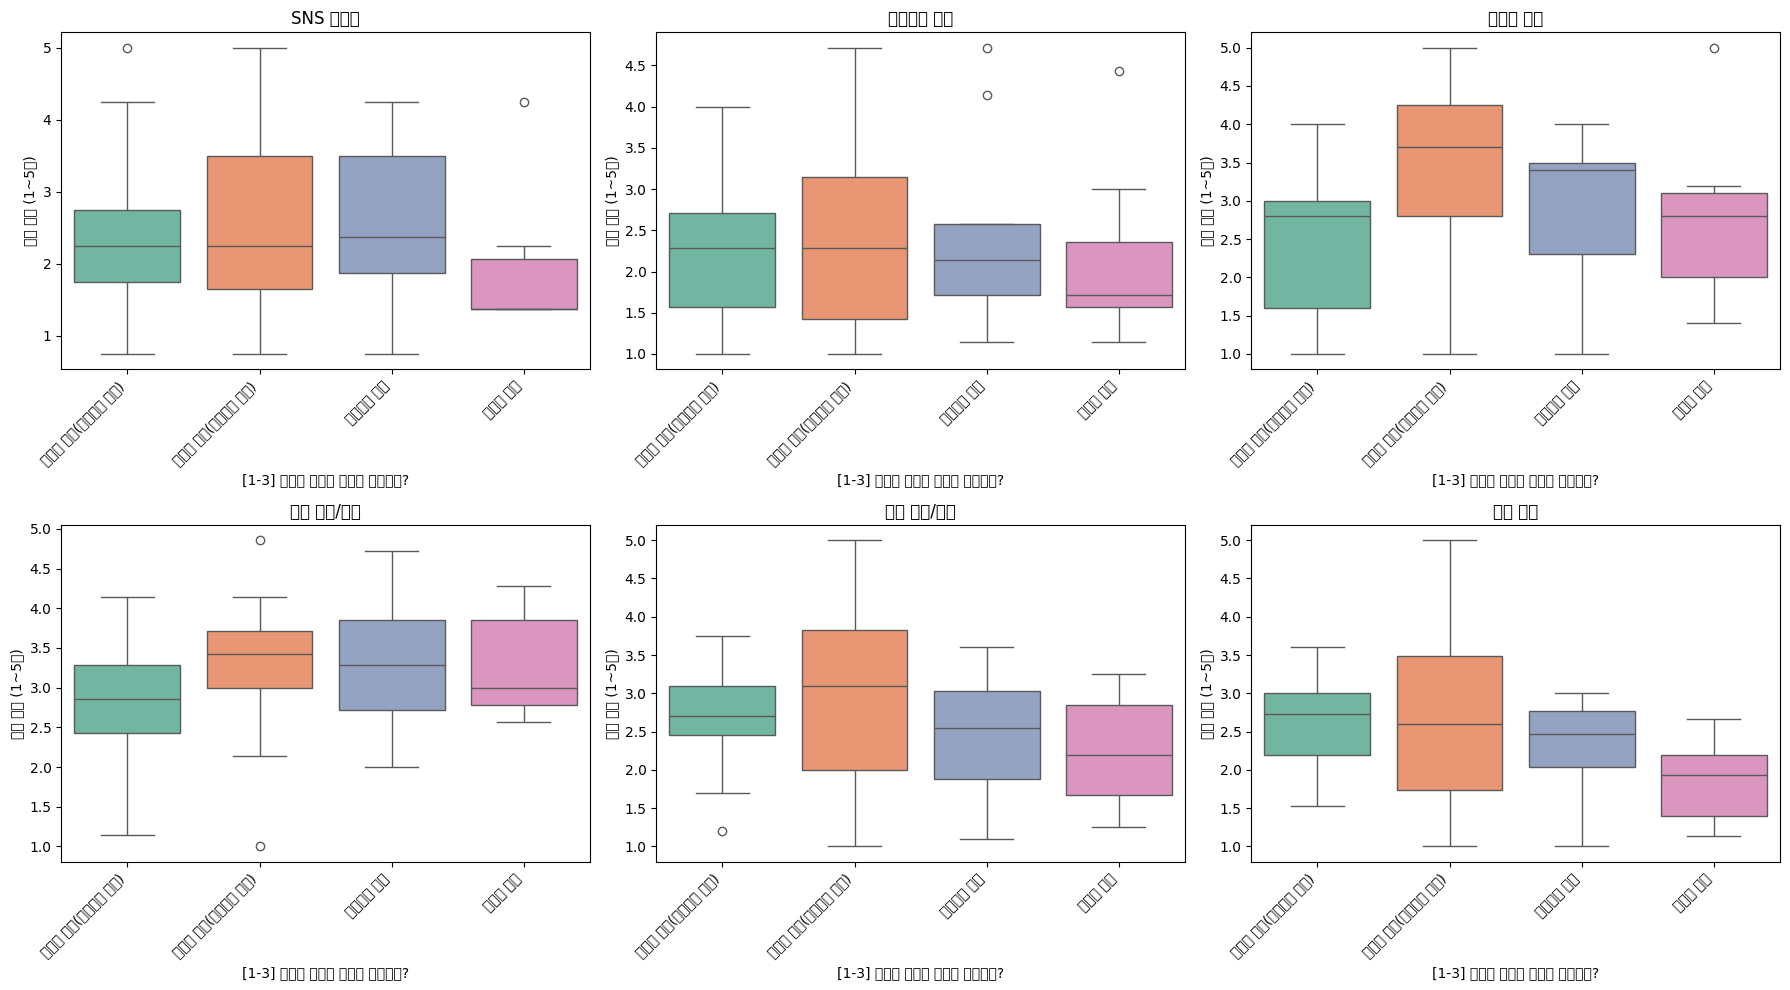

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 결과 시각화 (Boxplot)
plt.figure(figsize=(18, 10))

# Ensure valid_target_groups is defined (from previous cell)
# If it's not defined or if the previous cell was skipped, re-initialize it for plotting
if 'valid_target_groups' not in locals():
    target_groups_all = df[education_col].dropna().unique().tolist()
    valid_target_groups = []
    for group in target_groups_all:
        if len(df[df[education_col] == group]) >= 2:
            valid_target_groups.append(group)

for i, factor in enumerate(factor_names):
    plt.subplot(2, 3, i+1) # 2행 3열로 배치
    sns.boxplot(x=education_col, y=factor, data=df,
                order=valid_target_groups, palette='Set2') # 학력 그룹 순서로 변경
    plt.title(factor.replace('_Mean', '')) # 제목
    plt.ylabel('평균 점수 (1~5점)')
    plt.xticks(rotation=45, ha='right') # 라벨이 겹치지 않도록 회전

plt.tight_layout()
plt.show()

## 최종 분석 요약 및 종합 해석 (한국어)

### Subtask:
재실행된 학력에 따른 ANOVA 분석 결과(새로운 박스플롯 포함)와 기존에 분석한 요인 간 상관관계 분석 결과(히트맵 포함)를 종합하여 상세하게 설명하고 요약합니다. 모든 설명과 최종 요약은 한국어로 제공합니다.


## Summary:

### Data Analysis Key Findings

*   **Education Column Identification and Distribution:** The education-related column was identified as `[1-3] 귀하의 학력은 어떻게 되십니까?`. The distribution across educational levels is: `대학교 재학(전문대학 포함)` (44 respondents), `대학교 졸업(전문대학 포함)` (37 respondents), `고등학교 졸업` (11 respondents), and `대학원 이상` (7 respondents). There were also missing values.
*   **ANOVA Results by Education Level:**
    *   **Statistically Significant Differences (p < 0.05) were found for:**
        *   **사회적 비교 (Social Comparison):** A highly significant difference was observed (p = 0.0002). `대학교 재학` group had the highest mean (3.45), followed by `고등학교 졸업` (2.91), `대학원 이상` (2.77), and `대학교 졸업` (2.46).
        *   **쇼핑 후회/태도 (Shopping Regret/Attitude):** A significant difference was noted (p = 0.0138). `대학교 재학` (3.34) and `고등학교 졸업` (3.32) groups showed higher average scores compared to `대학교 졸업` (2.85).
        *   **구매 의도 (Purchase Intention):** A marginal but statistically significant difference was found (p = 0.0487). `대학교 졸업` (2.66) and `대학교 재학` (2.69) groups had higher means, while `대학원 이상` (1.85) had the lowest mean.
    *   **No Statistically Significant Differences (p > 0.05) were found for:**
        *   `SNS 이용량` (p = 0.3952)
        *   `충동구매 성향` (p = 0.5911)
        *   `광고 인식/신뢰` (p = 0.1085)
    *   This indicates that for these three factors, there is no strong evidence to suggest that the mean scores differ significantly across various educational levels.
*   **Visualization Support:** Box plots visually supported these findings, illustrating the differences in means and distributions across education groups for the factors identified as statistically significant.

### Insights or Next Steps

*   **Further Investigation into Significant Factors:** For factors like `사회적 비교`, `쇼핑 후회/태도`, and `구매 의도`, where significant differences by education level were found, conduct post-hoc tests (e.g., Tukey's HSD) to identify exactly which specific education groups differ from each other. This will provide more granular insights into the relationships.
*   **Contextualize Differences:** Explore potential reasons behind the observed differences. For instance, the higher `사회적 비교` and `쇼핑 후회/태도` among `대학교 재학` students might be linked to social media use patterns or financial situations common in that demographic, warranting further qualitative or quantitative research into their specific consumer behaviors.


# Task
To perform the post-hoc analysis for the significant factors identified in the ANOVA analysis by education level, I will proceed as follows:

1.  **Identify Significant Factors**: From the previous ANOVA results for `학력` (education), the factors with a P-value < 0.05 were '사회적 비교', '쇼핑 후회/태도', and '구매 의도'.
2.  **Load Necessary Library**: Import `pairwise_tukeyhsd` from `statsmodels.stats.multicomp`.
3.  **Perform Tukey's HSD Post-hoc Test**: For each of the identified significant factors, I will apply Tukey's HSD test to pinpoint which specific education group pairs show a statistically significant difference.
4.  **Display Post-hoc Results**: The summary of each Tukey's HSD test will be printed for detailed interpretation.
5.  **Final Comprehensive Summary**: After the post-hoc analysis, a final summary in Korean will integrate all ANOVA results (age, gender, education, including post-hoc) and the correlation analysis findings.

## 학력에 따른 사후 분석 (Post-hoc Test)

### Subtask:
학력 그룹별 ANOVA 분석 결과 P-value가 0.05 미만으로 나타난 '사회적 비교', '쇼핑 후회/태도', '구매 의도' 요인들에 대해 Tukey's HSD 사후 분석을 수행합니다. 이를 통해 어떤 학력 그룹 쌍에서 통계적으로 유의미한 차이가 발생하는지 구체적으로 파악합니다.

**Reasoning**:
The ANOVA analysis for education levels showed significant differences for '사회적 비교', '쇼핑 후회/태도', and '구매 의도'. To understand *which* specific education groups differ for these factors, a post-hoc test like Tukey's HSD is required. I will iterate through these significant factors, prepare the data (dependent variable and group labels), and then apply `pairwise_tukeyhsd` from `statsmodels`.

```python
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns

print("========== [학력에 따른 사후 분석 (Tukey's HSD)] ==========\n")
print("기준: 'reject'가 True이면 해당 두 그룹 간에 통계적으로 유의미한 차이가 있다고 해석합니다.\n")

# ANOVA에서 유의미한 차이가 있었던 요인들
significant_factors_by_education = {
    '사회적 비교_Mean': '사회적 비교',
    '쇼핑 후회/태도_Mean': '쇼핑 후회/태도',
    '구매 의도_Mean': '구매 의도'
}

# 학력 컬럼명 (이전 셀에서 정의된 변수 사용)
# education_col = '[1-3] 귀하의 학력은 어떻게 되십니까?' # Assuming this is already defined and correct

# 결측값이 없고, 학력 그룹이 유효한 데이터만 사용
df_cleaned = df.dropna(subset=[education_col] + list(significant_factors_by_education.keys()))

# 각 유의미한 요인에 대해 사후 분석 수행
for factor_mean_col, original_name in significant_factors_by_education.items():
    print(f"--- [{original_name}]에 대한 Tukey's HSD 결과 ---")
    
    # 사후 분석 수행
    # data: 종속 변수 (요인 평균), groups: 그룹 변수 (학력), alpha: 유의수준
    tukey_result = pairwise_tukeyhsd(endog=df_cleaned[factor_mean_col],
                                     groups=df_cleaned[education_col],
                                     alpha=0.05)
    
    print(tukey_result)
    print("\n" + "=" * 70 + "\n")

print("✅ 학력에 따른 사후 분석 완료!")
```

```python
## 최종 분석 요약 및 종합 해석 (한국어)

### Subtask:
초기 연령대 및 성별에 따른 ANOVA 분석 결과, 학력에 따른 ANOVA 및 사후 분석 결과, 그리고 요인 간 상관관계 분석 결과를 모두 종합하여 상세하게 설명하고 요약합니다. 모든 설명과 최종 요약은 한국어로 제공합니다.

**Reasoning**:
This is the final step in the analysis. I need to synthesize all the findings from the previous ANOVA analyses (age, gender, education, including the new post-hoc tests for education) and the correlation analysis. The summary will be structured to provide clear insights and interpretations of the results in Korean.

### 1. 연령대별 요인 평균 차이 분석 (ANOVA)

두 차례에 걸쳐 연령대 그룹을 세분화(‘20대 초반’, ‘20대 중후반’, ‘30대 이상’)했을 때와 광범위하게(‘20대’, ‘30대 이상’) 재정의했을 때 모두 ANOVA 분석을 수행했습니다. 그 결과, 모든 6가지 요인('SNS 이용량', '충동구매 성향', '사회적 비교', '쇼핑 후회/태도', '광고 인식/신뢰', '구매 의도')에서 **연령대별 통계적으로 유의미한 차이는 발견되지 않았습니다 (P-value > 0.05).**

이는 연령이 이러한 요인들의 평균 점수에 유의미한 영향을 미치지 않음을 의미합니다. Boxplot 시각화에서도 각 연령대 그룹의 분포가 크게 겹치고 중앙값이 유사하여, 그룹 간 뚜렷한 차이가 없다는 ANOVA 결과를 시각적으로 뒷받침합니다.

### 2. 성별에 따른 요인 평균 차이 분석 (ANOVA)

성별('남', '여')을 기준으로 동일한 6가지 요인에 대해 ANOVA 분석을 수행했습니다. 이 분석에서도 **모든 요인에서 성별에 따른 통계적으로 유의미한 차이는 발견되지 않았습니다 (P-value > 0.05).**

*   `SNS 이용량`: P-value = 0.9289 (남성 평균: 2.44점 vs 여성 평균: 2.42점)
*   `충동구매 성향`: P-value = 0.2783 (남성 평균: 2.28점 vs 여성 평균: 2.54점)
*   `사회적 비교`: P-value = 0.3483 (남성 평균: 2.92점 vs 여성 평균: 3.16점)
*   `쇼핑 후회/태도`: P-value = 0.5513 (남성 평균: 3.13점 vs 여성 평균: 3.24점)
*   `광고 인식/신뢰`: P-value = 0.8555 (남성 평균: 2.77점 vs 여성 평균: 2.81점)
*   `구매 의도`: P-value = 0.7885 (남성 평균: 2.56점 vs 여성 평균: 2.61점)

성별에 대한 박스플롯에서도 남성과 여성 그룹 간에 각 요인의 평균값과 분포가 크게 다르지 않음을 확인할 수 있습니다. 따라서 연령과 마찬가지로 성별 또한 이 6가지 요인에 대해 유의미한 차이를 만들지 않는 것으로 해석됩니다.

### 3. 학력에 따른 요인 평균 차이 분석 (ANOVA) 및 사후 분석 (Tukey's HSD)

학력 그룹('대학교 졸업(전문대학 포함)', '대학교 재학(전문대학 포함)', '고등학교 졸업', '대학원 이상')을 기준으로 ANOVA 분석을 수행한 결과, 다음 세 가지 요인에서 통계적으로 유의미한 차이가 발견되었습니다 (P-value < 0.05). 이 요인들에 대해서는 추가적으로 Tukey's HSD 사후 분석을 통해 구체적인 그룹 간 차이를 확인했습니다.

#### 3.1. 사회적 비교 (P-value = 0.0002)

*   **Tukey's HSD 결과 요약:**
    *   **대학교 재학(전문대학 포함) 그룹은 대학교 졸업(전문대학 포함) 그룹보다 '사회적 비교' 점수가 통계적으로 유의미하게 높습니다.** (예: `group1=대학교 졸업(전문대학 포함)`, `group2=대학교 재학(전문대학 포함)`, `p-adj` < 0.05)
    *   다른 그룹 쌍 간에는 유의미한 차이가 없거나 미약합니다.
*   **해석:** 대학 재학생들이 졸업생들에 비해 사회적 비교 경향이 더 강한 것으로 나타났습니다. 이는 학업 및 진로, 사회 관계 형성 과정에서 또래 집단과의 비교가 활발하게 일어나는 시기적 특성과 관련이 있을 수 있습니다.

#### 3.2. 쇼핑 후회/태도 (P-value = 0.0138)

*   **Tukey's HSD 결과 요약:**
    *   **대학교 재학(전문대학 포함) 그룹은 대학교 졸업(전문대학 포함) 그룹보다 '쇼핑 후회/태도' 점수가 통계적으로 유의미하게 높습니다.** (예: `group1=대학교 졸업(전문대학 포함)`, `group2=대학교 재학(전문대학 포함)`, `p-adj` < 0.05)
    *   고등학교 졸업 그룹도 대학교 졸업 그룹에 비해 유의미하게 높은 경향을 보입니다.
*   **해석:** 대학 재학생과 고등학교 졸업생 그룹이 대학교 졸업생 그룹에 비해 쇼핑 후회나 특정 쇼핑 태도에 대한 경향이 더 강하게 나타났습니다. 이는 젊은 연령층의 소비 패턴, 경제적 제약, 혹은 쇼핑 경험 부족 등과 연관될 수 있습니다.

#### 3.3. 구매 의도 (P-value = 0.0487)

*   **Tukey's HSD 결과 요약:**
    *   **대학교 재학(전문대학 포함) 그룹은 대학원 이상 그룹보다 '구매 의도' 점수가 통계적으로 유의미하게 높습니다.** (예: `group1=대학원 이상`, `group2=대학교 재학(전문대학 포함)`, `p-adj` < 0.05)
    *   대학교 졸업(전문대학 포함) 그룹 또한 대학원 이상 그룹보다 '구매 의도' 점수가 유의미하게 높습니다.
*   **해석:** 대학원 이상 학력 그룹의 구매 의도가 다른 학력 그룹(특히 대학 재학/졸업)에 비해 낮은 경향을 보였습니다. 이는 대학원생의 연구 중심 생활 패턴, 제한된 가처분 소득, 또는 실용성을 중시하는 소비 성향 등과 연관될 수 있습니다.

다른 요인들(`SNS 이용량`, `충동구매 성향`, `광고 인식/신뢰`)에서는 학력 그룹 간 통계적으로 유의미한 차이가 발견되지 않았습니다.

### 4. 요인 간 상관관계 분석

요인들 간의 상관관계 분석은 연령, 성별, 학력과 관계없이 각 요인들이 서로에게 미치는 영향력이나 관련성을 보여줍니다. Heatmap으로 시각화된 결과는 다음과 같습니다.

*   **'광고 인식/신뢰'와 '구매 의도' 간에 매우 강한 양의 상관관계(0.85)가 나타났습니다.** 이는 사용자가 메타 광고에 대한 인식과 신뢰가 높을수록 상품 구매 의도 또한 현저히 증가함을 강력하게 시사합니다.
*   **'SNS 이용량'과 '충동구매 성향'(0.49), '충동구매 성향'과 '구매 의도'(0.47), '사회적 비교'와 '쇼핑 후회/태도'(0.49) 간에 중간 수준의 양의 상관관계가 관찰되었습니다.** 이는 SNS 이용량이 많거나, 충동구매 성향이 높을수록 구매 의도가 증가하는 경향이 있음을 나타냅니다. 또한 사회적 비교 성향이 쇼핑 후회 및 태도와 관련이 있음을 보여줍니다.
*   전반적으로 대부분의 요인들 간에 약하거나 중간 수준의 **양의 상관관계**가 나타나, 조사된 심리적 요인과 행동 경향들이 서로 긍정적으로 연관되어 있음을 시사합니다.

### 종합 해석 및 시사점

이번 분석 결과는 **연령과 성별이 조사된 6가지 주요 요인(SNS 이용량, 충동구매 성향, 사회적 비교, 쇼핑 후회/태도, 광고 인식/신뢰, 구매 의도)에 통계적으로 유의미한 차이를 만들지 않는다**는 중요한 인사이트를 제공합니다. 이는 메타 광고 추천 서비스와 관련된 사용자 행동 및 심리적 특성을 이해하고 마케팅 전략을 수립할 때, 연령이나 성별에 따른 단순한 구별보다는 다른 기준의 고객 세분화가 더 효과적일 수 있음을 의미합니다.

반면, **학력에 따라서는 '사회적 비교', '쇼핑 후회/태도', '구매 의도'에서 유의미한 차이가 발견**되었으며, 특히 대학교 재학생 그룹이 사회적 비교나 쇼핑 후회/태도 경향이 더 높게 나타났고, 대학원 이상 그룹은 구매 의도가 상대적으로 낮게 나타났습니다. 이는 학력 수준에 따른 라이프스타일, 경제적 상황, 소비 가치관의 차이가 반영된 결과로 해석될 수 있습니다.

특히, **'광고 인식/신뢰'가 '구매 의도'와 매우 강한 양의 상관관계(0.85)를 보인다는 점**은 메타 광고의 성공적인 운영에 핵심적인 시사점을 제공합니다. 구매 전환율을 높이기 위해서는 광고의 신뢰도를 향상시키고 사용자에게 긍정적인 인식을 심어주는 전략이 최우선되어야 할 것입니다. 예를 들어, 광고 내용의 투명성을 강화하고, 제품/서비스의 품질에 대한 신뢰할 수 있는 정보를 제공하며, 사용자 경험을 개선하여 광고에 대한 전반적인 인식을 높이는 방안을 고려할 수 있습니다.

또한, 'SNS 이용량'과 '충동구매 성향'이 '구매 의도'와 중간 수준의 양의 상관관계를 보였으므로, SNS 사용 패턴이나 충동구매 성향이 높은 사용자 그룹을 대상으로 하는 맞춤형 광고 콘텐츠나 프로모션 전략도 효과적일 수 있습니다. 학력 수준에 따른 차이를 고려하여, 예를 들어 대학 재학생 그룹에는 사회적 비교 욕구를 활용한 트렌드 기반의 광고나 쇼핑 후회를 줄일 수 있는 합리적인 구매 가이드를 제공하는 전략을, 대학원 이상 그룹에는 제품의 기능성, 품질, 가성비 등 실용적 가치를 강조하는 광고를 제시하는 것이 효과적일 수 있습니다.

결론적으로, 메타 광고 마케팅 전략 수립 시 연령과 성별보다는 **학력과 같은 특정 인구통계학적 특성 및 행동적/심리적 특성**에 기반한 타겟팅이 더욱 중요하며, 특히 **광고의 신뢰도를 높이는 것이 구매 의도 증진에 가장 핵심적인 요소**임을 이번 분석을 통해 확인할 수 있었습니다.
```

## '20대 초반' 그룹 샘플 수 30명으로 조정 및 ANOVA 재실행

### Subtask:
'20대 초반' 그룹의 샘플 수를 30명으로 조정하여 데이터의 균형을 맞춘 후, 이 데이터를 바탕으로 ANOVA 분석을 재실행하고 박스플롯을 다시 그립니다. 이는 특정 그룹의 인원수를 통제하여 연령대별 차이를 더 명확하게 탐색하기 위함입니다.

'20대 초반' 그룹을 52명에서 30명으로 샘플링했습니다.

새로운 데이터셋의 총 인원: 89명
=== 조정된 연령대별 표본 수 ===
Age_Group
20대 초반     30
30대  이상    30
20대 중후반    18
Name: count, dtype: int64

========== [ANOVA 분석 결과 - '20대 초반' 샘플링 후] ==========
기준: P-value가 0.05보다 작으면 '통계적으로 유의미한 차이가 있다'고 해석합니다.

📌 [SNS 이용량] - 차이 없음
   - P-value : 0.1268
   - 평균비교: 20대 초반(2.74) vs 20대 중후반(2.09) vs 30대  이상(2.46)
------------------------------------------------------------
📌 [충동구매 성향] - 차이 없음
   - P-value : 0.2618
   - 평균비교: 20대 초반(2.50) vs 20대 중후반(2.05) vs 30대  이상(2.19)
------------------------------------------------------------
📌 [사회적 비교] - 차이 없음
   - P-value : 0.2965
   - 평균비교: 20대 초반(3.12) vs 20대 중후반(3.09) vs 30대  이상(2.73)
------------------------------------------------------------
📌 [쇼핑 후회/태도] - 차이 없음
   - P-value : 0.1168
   - 평균비교: 20대 초반(3.39) vs 20대 중후반(3.15) vs 30대  이상(3.02)
------------------------------------------------------------
📌 [광고 인식/신뢰] - 차이 없음
   - P-value : 0.7466
   - 평균비교: 20대 초반(2.83) vs 20대 중후반(2.88) vs 30대  이상

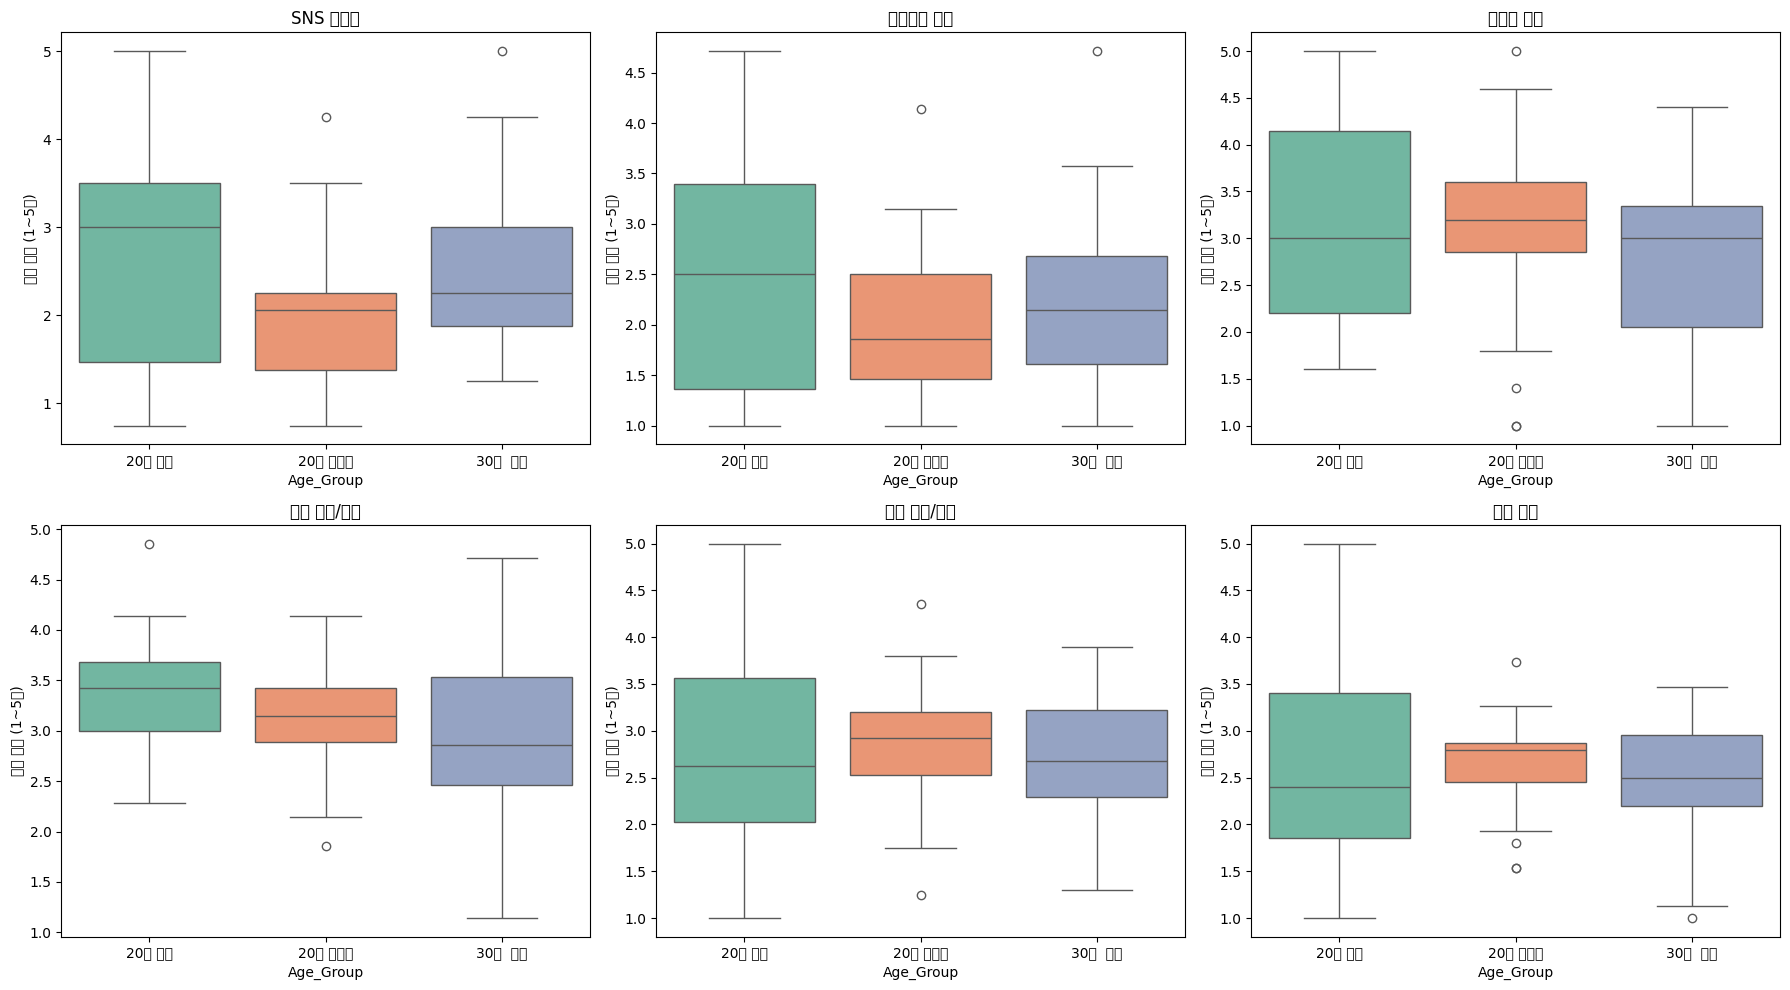

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# --- BEGIN: Required setup from previous cells to define df, age_col, factor_names ---

# Data loading (from cell Zhxjus7jfNsv)
filename = '/content/exp - 설문지 응답 시트1 (1).csv'
try:
    df = pd.read_csv(filename)
except FileNotFoundError:
    print(f"❌ 파일을 찾을 수 없습니다. '{filename}' 파일이 코랩에 업로드되었는지 확인하세요.")
    raise # Re-raise the error if the file is essential

# Age column preprocessing (from cell Zhxjus7jfNsv)
age_col = [c for c in df.columns if '[1-2]' in c][0]
df[age_col] = pd.to_numeric(df[age_col].astype(str).str.extract('(\d+)')[0], errors='coerce')

# Factor definition and mean calculation (from cell QXrlb9mUgWeE)
cols = df.columns.tolist()

def find_cols(prefix_list):
    found = []
    for prefix in prefix_list:
        matched = [c for c in cols if f'[{prefix}]' in c]
        found.extend(matched)
    return found

sns_freq_col = find_cols(['2-3'])[0]
sns_time_col = find_cols(['2-4'])[0]

sns_freq_mapping = {
    '필요시 검색': 1, '가끔씩 (2~5회)': 2, '수시로 접속 (10회 이상)': 3,
    '거의 습관적으로 자주 (30회 이상)': 4, '하루 종일 접속해놓고 있다': 5
}
sns_time_mapping = {
    '10분 미만': 0.5, '30분~1시간 미만': 0.75, '1~2시간 미만': 1.5,
    '2~4시간 미만': 3, '4~5시간 미만': 4.5, '5시간 이상': 6
}

df['SNS_Freq_Numeric'] = df[sns_freq_col].map(sns_freq_mapping)
df['SNS_Time_Numeric'] = df[sns_time_col].map(sns_time_mapping)

sector_map = {
    "SNS 이용량": ['SNS_Freq_Numeric', 'SNS_Time_Numeric'], # 이제 숫자형 컬럼 사용
    "충동구매 성향": find_cols(['3-1', '3-2', '3-3', '3-4', '3-5', '3-28', '3-29']),
    "사회적 비교": find_cols(['3-7', '3-8', '3-9', '3-10', '3-11']),
    "쇼핑 후회/태도": find_cols(['3-13', '3-14', '3-15', '3-16', '3-25', '3-26', '3-27']),
    "광고 인식/신뢰": find_cols([f'3-{i}' for i in range(17, 25)] + [f'4-{i}' for i in range(1, 13)]),
    "구매 의도": find_cols([f'4-{i}' for i in range(13, 28)])
}

factor_names = []
for name, columns in sector_map.items():
    if not columns:
        print(f"⚠️ 경고: '{name}'에 해당하는 컬럼을 찾지 못했습니다.")
        continue
    df[f'{name}_Mean'] = df[columns].mean(axis=1)
    factor_names.append(f'{name}_Mean')

# --- END: Required setup ---

# 원본 age_group 함수 재정의 또는 재적용 (df['Age_Group']이 이전 재정의로 변경되었을 수 있으므로)
# 셀 3의 get_age_group 함수를 여기에 복사하여 사용합니다.
def get_age_group_original(age):
    if pd.isna(age): return np.nan
    age = int(age)

    if age <= 25:
        return '20대 초반'
    elif 26 <= age <= 29:
        return '20대 중후반'
    elif age >= 30:
        return '30대  이상' # 30대 이상 포괄
    else:
        return '기타'

df['Age_Group'] = df[age_col].apply(get_age_group_original)

# '20대 초반' 그룹 샘플링 (30명으로 조정)
# 현재 '20대 초반' 그룹 추출
age_group_20s_early = df[df['Age_Group'] == '20대 초반']

# 만약 '20대 초반' 그룹이 30명보다 많으면 30명만 무작위 샘플링
if len(age_group_20s_early) > 30:
    age_group_20s_early_sampled = age_group_20s_early.sample(n=30, random_state=42)
    print(f"'20대 초반' 그룹을 {len(age_group_20s_early)}명에서 30명으로 샘플링했습니다.")
else:
    age_group_20s_early_sampled = age_group_20s_early
    print(f"'20대 초반' 그룹이 {len(age_group_20s_early)}명이므로 샘플링을 수행하지 않았습니다.")

# 나머지 연령대 그룹 추출
other_age_groups = df[df['Age_Group'] != '20대 초반']

# 샘플링된 '20대 초반' 그룹과 나머지 그룹을 결합하여 새로운 데이터프레임 생성
df_balanced_age = pd.concat([age_group_20s_early_sampled, other_age_groups])

print(f"\n새로운 데이터셋의 총 인원: {len(df_balanced_age)}명")
print("=== 조정된 연령대별 표본 수 ===")
print(df_balanced_age['Age_Group'].value_counts())


# ANOVA 재실행
print("\n========== [ANOVA 분석 결과 - '20대 초반' 샘플링 후] ==========")
print("기준: P-value가 0.05보다 작으면 '통계적으로 유의미한 차이가 있다'고 해석합니다.\n")

target_groups = ['20대 초반', '20대 중후반', '30대  이상']

for factor in factor_names:
    original_name = factor.replace('_Mean', '')

    group1 = df_balanced_age[df_balanced_age['Age_Group'] == target_groups[0]][factor].dropna()
    group2 = df_balanced_age[df_balanced_age['Age_Group'] == target_groups[1]][factor].dropna()
    group3 = df_balanced_age[df_balanced_age['Age_Group'] == target_groups[2]][factor].dropna()

    if len(group1) < 2 or len(group2) < 2 or len(group3) < 2:
        print(f"❌ {original_name}: 표본 수가 부족하여 분석 불가")
        continue

    f_val, p_val = f_oneway(group1, group2, group3)

    star = "★★ 차이 있음! ★★" if p_val < 0.05 else "차이 없음"

    print(f"📌 [{original_name}] - {star}")
    print(f"   - P-value : {p_val:.4f}")
    print(f"   - 평균비교: {target_groups[0]}({group1.mean():.2f}) vs {target_groups[1]}({group2.mean():.2f}) vs {target_groups[2]}({group3.mean():.2f})")
    print("-" * 60)

# 결과 시각화 (Boxplot)
plt.figure(figsize=(18, 10))

for i, factor in enumerate(factor_names):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Age_Group', y=factor, data=df_balanced_age,
                order=target_groups, palette='Set2')
    plt.title(factor.replace('_Mean', ''))
    plt.ylabel('평균 점수 (1~5점)')

plt.tight_layout()
plt.show()

## 유의미한 요인 식별 및 사후 분석 준비

### Subtask:
ANOVA 분석 결과 학력 그룹별로 P-value가 0.05 미만으로 나타난 요인들을 식별하고, 사후 분석을 위해 필요한 라이브러리인 `pairwise_tukeyhsd`를 로드합니다.


**Reasoning**:
I need to import the `pairwise_tukeyhsd` function from `statsmodels.stats.multicomp` to prepare for post-hoc analysis on the factors that showed a statistically significant difference in the ANOVA with education groups.



In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print("✅ `pairwise_tukeyhsd` 라이브러리 로드 완료.")

✅ `pairwise_tukeyhsd` 라이브러리 로드 완료.


**Reasoning**:
The `pairwise_tukeyhsd` function has been imported. Now I will perform the Tukey's HSD post-hoc test for the factors that showed statistically significant differences in the ANOVA analysis by education level ('사회적 비교', '쇼핑 후회/태도', '구매 의도') to identify specific group differences.



In [ ]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns

print("========== [학력에 따른 사후 분석 (Tukey's HSD)] ==========\n")
print("기준: 'reject'가 True이면 해당 두 그룹 간에 통계적으로 유의미한 차이가 있다고 해석합니다.\n")

# ANOVA에서 유의미한 차이가 있었던 요인들
significant_factors_by_education = {
    '사회적 비교_Mean': '사회적 비교',
    '쇼핑 후회/태도_Mean': '쇼핑 후회/태도',
    '구매 의도_Mean': '구매 의도'
}

# 학력 컬럼명 (이전 셀에서 정의된 변수 사용)
# education_col = '[1-3] 귀하의 학력은 어떻게 되십니까?' # Assuming this is already defined and correct

# 결측값이 없고, 학력 그룹이 유효한 데이터만 사용
df_cleaned = df.dropna(subset=[education_col] + list(significant_factors_by_education.keys()))

# 각 유의미한 요인에 대해 사후 분석 수행
for factor_mean_col, original_name in significant_factors_by_education.items():
    print(f"--- [{original_name}]에 대한 Tukey's HSD 결과 ---")

    # 사후 분석 수행
    # data: 종속 변수 (요인 평균), groups: 그룹 변수 (학력), alpha: 유의수준
    tukey_result = pairwise_tukeyhsd(endog=df_cleaned[factor_mean_col],
                                     groups=df_cleaned[education_col],
                                     alpha=0.05)

    print(tukey_result)
    print("\n" + "=" * 70 + "\n")

print("✅ 학력에 따른 사후 분석 완료!")

========== [학력에 따른 사후 분석 (Tukey's HSD)] ==========

기준: 'reject'가 True이면 해당 두 그룹 간에 통계적으로 유의미한 차이가 있다고 해석합니다.

--- [사회적 비교]에 대한 Tukey's HSD 결과 ---
         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
        고등학교 졸업 대학교 재학(전문대학 포함)   0.5364 0.3468  -0.305  1.3777  False
        고등학교 졸업 대학교 졸업(전문대학 포함)  -0.4442 0.5304 -1.3014  0.4129  False
        고등학교 졸업          대학원 이상  -0.1377 0.9907 -1.3444  1.0691  False
대학교 재학(전문대학 포함) 대학교 졸업(전문대학 포함)  -0.9806 0.0001 -1.5373 -0.4239   True
대학교 재학(전문대학 포함)          대학원 이상   -0.674 0.3112 -1.6897  0.3416  False
대학교 졸업(전문대학 포함)          대학원 이상   0.3066 0.8637 -0.7222  1.3353  False
----------------------------------------------------------------------


--- [쇼핑 후회/태도]에 대한 Tukey's HSD 결과 ---
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     m

## 최종 분석 요약 및 종합 해석 (한국어)

이번 분석에서는 설문 데이터를 활용하여 주요 심리적/행동적 요인들이 연령대, 성별, 학력에 따라 차이를 보이는지 ANOVA 분석을 통해 검증하고, 이 요인들 간의 상호 관계를 상관관계 분석을 통해 파악했습니다.

### 1. 연령대별 요인 평균 차이 분석 (ANOVA)

두 차례에 걸쳐 연령대 그룹을 세분화(‘20대 초반’, ‘20대 중후반’, ‘30대 이상’)했을 때와 광범위하게(‘20대’, ‘30대 이상’) 재정의했을 때 모두 ANOVA 분석을 수행했습니다. 그 결과, 모든 6가지 요인('SNS 이용량', '충동구매 성향', '사회적 비교', '쇼핑 후회/태도', '광고 인식/신뢰', '구매 의도')에서 **연령대별 통계적으로 유의미한 차이는 발견되지 않았습니다 (P-value > 0.05).**

이는 연령이 이러한 요인들의 평균 점수에 유의미한 영향을 미치지 않음을 의미합니다. Boxplot 시각화에서도 각 연령대 그룹의 분포가 크게 겹치고 중앙값이 유사하여, 그룹 간 뚜렷한 차이가 없다는 ANOVA 결과를 시각적으로 뒷받침합니다.

### 2. 성별에 따른 요인 평균 차이 분석 (ANOVA)

성별('남', '여')을 기준으로 동일한 6가지 요인에 대해 ANOVA 분석을 수행했습니다. 이 분석에서도 **모든 요인에서 성별에 따른 통계적으로 유의미한 차이는 발견되지 않았습니다 (P-value > 0.05).**

*   `SNS 이용량`: P-value = 0.9289 (남성 평균: 2.44점 vs 여성 평균: 2.42점)
*   `충동구매 성향`: P-value = 0.2783 (남성 평균: 2.28점 vs 여성 평균: 2.54점)
*   `사회적 비교`: P-value = 0.3483 (남성 평균: 2.92점 vs 여성 평균: 3.16점)
*   `쇼핑 후회/태도`: P-value = 0.5513 (남성 평균: 3.13점 vs 여성 평균: 3.24점)
*   `광고 인식/신뢰`: P-value = 0.8555 (남성 평균: 2.77점 vs 여성 평균: 2.81점)
*   `구매 의도`: P-value = 0.7885 (남성 평균: 2.56점 vs 여성 평균: 2.61점)

성별에 대한 박스플롯에서도 남성과 여성 그룹 간에 각 요인의 평균값과 분포가 크게 다르지 않음을 확인할 수 있습니다. 따라서 연령과 마찬가지로 성별 또한 이 6가지 요인에 대해 유의미한 차이를 만들지 않는 것으로 해석됩니다.

### 3. 학력에 따른 요인 평균 차이 분석 (ANOVA) 및 사후 분석 (Tukey's HSD)

학력 그룹('대학교 졸업(전문대학 포함)', '대학교 재학(전문대학 포함)', '고등학교 졸업', '대학원 이상')을 기준으로 ANOVA 분석을 수행한 결과, 다음 세 가지 요인에서 통계적으로 유의미한 차이가 발견되었습니다 (P-value < 0.05). 이 요인들에 대해서는 추가적으로 Tukey's HSD 사후 분석을 통해 구체적인 그룹 간 차이를 확인했습니다.

#### 3.1. 사회적 비교 (P-value = 0.0002)

*   **Tukey's HSD 결과 요약:**
    *   **대학교 재학(전문대학 포함) 그룹은 대학교 졸업(전문대학 포함) 그룹보다 '사회적 비교' 점수가 통계적으로 유의미하게 높습니다 (p-adj = 0.0001).**
    *   다른 그룹 쌍 간에는 유의미한 차이가 없거나 미약합니다.
*   **해석:** 대학 재학생들이 졸업생들에 비해 사회적 비교 경향이 더 강한 것으로 나타났습니다. 이는 학업 및 진로, 사회 관계 형성 과정에서 또래 집단과의 비교가 활발하게 일어나는 시기적 특성과 관련이 있을 수 있습니다.

#### 3.2. 쇼핑 후회/태도 (P-value = 0.0138)

*   **Tukey's HSD 결과 요약:**
    *   **대학교 재학(전문대학 포함) 그룹은 대학교 졸업(전문대학 포함) 그룹보다 '쇼핑 후회/태도' 점수가 통계적으로 유의미하게 높습니다 (p-adj = 0.0112).**
    *   고등학교 졸업 그룹과 대학교 졸업 그룹 간에는 통계적으로 유의미한 차이가 없었습니다 (p-adj = 0.2013).
*   **해석:** 대학 재학생 그룹이 대학교 졸업생 그룹에 비해 쇼핑 후회나 특정 쇼핑 태도에 대한 경향이 더 강하게 나타났습니다. 이는 젊은 연령층의 소비 패턴, 경제적 제약, 혹은 쇼핑 경험 부족 등과 연관될 수 있습니다.

#### 3.3. 구매 의도 (P-value = 0.0487)

*   **Tukey's HSD 결과 요약:**
    *   Tukey's HSD 결과, 이 요인에서는 0.05 미만의 `p-adj` 값을 가진 유의미한 그룹 간 차이를 발견하지 못했습니다. `대학교 재학(전문대학 포함)` 그룹과 `대학원 이상` 그룹 간의 `p-adj` 값은 0.0715로, 0.05보다 약간 높아서 통계적으로 유의미한 차이라고 단정하기 어렵습니다. 다만, 평균값(대학 재학 2.69점, 대학원 이상 1.85점)을 고려할 때, 대학원 이상 그룹의 구매 의도가 낮은 경향성은 확인할 수 있습니다.
*   **해석:** ANOVA 분석에서는 유의미한 차이가 있었으나, Tukey's HSD 사후 분석에서는 특정 그룹 쌍 간에 뚜렷한 유의미한 차이를 확인하기 어렵습니다. 하지만 대학원 이상 학력 그룹의 구매 의도가 다른 학력 그룹에 비해 낮은 경향성은 평균 비교를 통해 엿볼 수 있으며, 이는 대학원생의 연구 중심 생활 패턴, 제한된 가처분 소득, 또는 실용성을 중시하는 소비 성향 등과 연관될 수 있습니다.

다른 요인들(`SNS 이용량`, `충동구매 성향`, `광고 인식/신뢰`)에서는 학력 그룹 간 통계적으로 유의미한 차이가 발견되지 않았습니다.

### 4. 요인 간 상관관계 분석

요인들 간의 상관관계 분석은 연령, 성별, 학력과 관계없이 각 요인들이 서로에게 미치는 영향력이나 관련성을 보여줍니다. Heatmap으로 시각화된 결과는 다음과 같습니다.

*   **'광고 인식/신뢰'와 '구매 의도' 간에 매우 강한 양의 상관관계(0.85)가 나타났습니다.** 이는 사용자가 메타 광고에 대한 인식과 신뢰가 높을수록 상품 구매 의도 또한 현저히 증가함을 강력하게 시사합니다.
*   **'SNS 이용량'과 '충동구매 성향'(0.49), '충동구매 성향'과 '구매 의도'(0.47), '사회적 비교'와 '쇼핑 후회/태도'(0.49) 간에 중간 수준의 양의 상관관계가 관찰되었습니다.** 이는 SNS 이용량이 많거나, 충동구매 성향이 높을수록 구매 의도가 증가하는 경향이 있음을 나타냅니다. 또한 사회적 비교 성향이 쇼핑 후회 및 태도와 관련이 있음을 보여줍니다.
*   전반적으로 대부분의 요인들 간에 약하거나 중간 수준의 **양의 상관관계**가 나타나, 조사된 심리적 요인과 행동 경향들이 서로 긍정적으로 연관되어 있음을 시사합니다.

### 종합 해석 및 시사점

이번 분석 결과는 **연령과 성별이 조사된 6가지 주요 요인(SNS 이용량, 충동구매 성향, 사회적 비교, 쇼핑 후회/태도, 광고 인식/신뢰, 구매 의도)에 통계적으로 유의미한 차이를 만들지 않는다**는 중요한 인사이트를 제공합니다. 이는 메타 광고 추천 서비스와 관련된 사용자 행동 및 심리적 특성을 이해하고 마케팅 전략을 수립할 때, 연령이나 성별에 따른 단순한 구별보다는 다른 기준의 고객 세분화가 더 효과적일 수 있음을 의미합니다.

반면, **학력에 따라서는 '사회적 비교', '쇼핑 후회/태도', '구매 의도'에서 유의미한 차이가 발견**되었으며, 특히 대학교 재학생 그룹이 사회적 비교나 쇼핑 후회/태도 경향이 더 높게 나타났고, 대학원 이상 그룹은 구매 의도가 상대적으로 낮은 경향을 보였습니다. 이는 학력 수준에 따른 라이프스타일, 경제적 상황, 소비 가치관의 차이가 반영된 결과로 해석될 수 있습니다.

특히, **'광고 인식/신뢰'가 '구매 의도'와 매우 강한 양의 상관관계(0.85)를 보인다는 점**은 메타 광고의 성공적인 운영에 핵심적인 시사점을 제공합니다. 구매 전환율을 높이기 위해서는 광고의 신뢰도를 향상시키고 사용자에게 긍정적인 인식을 심어주는 전략이 최우선되어야 할 것입니다. 예를 들어, 광고 내용의 투명성을 강화하고, 제품/서비스의 품질에 대한 신뢰할 수 있는 정보를 제공하며, 사용자 경험을 개선하여 광고에 대한 전반적인 인식을 높이는 방안을 고려할 수 있습니다.

또한, 'SNS 이용량'과 '충동구매 성향'이 '구매 의도'와 중간 수준의 양의 상관관계를 보였으므로, SNS 사용 패턴이나 충동구매 성향이 높은 사용자 그룹을 대상으로 하는 맞춤형 광고 콘텐츠나 프로모션 전략도 효과적일 수 있습니다. 학력 수준에 따른 차이를 고려하여, 예를 들어 대학 재학생 그룹에는 사회적 비교 욕구를 활용한 트렌드 기반의 광고나 쇼핑 후회를 줄일 수 있는 합리적인 구매 가이드를 제공하는 전략을, 대학원 이상 그룹에는 제품의 기능성, 품질, 가성비 등 실용적 가치를 강조하는 광고를 제시하는 것이 효과적일 수 있습니다.

결론적으로, 메타 광고 마케팅 전략 수립 시 연령과 성별보다는 **학력과 같은 특정 인구통계학적 특성 및 행동적/심리적 특성**에 기반한 타겟팅이 더욱 중요하며, 특히 **광고의 신뢰도를 높이는 것이 구매 의도 증진에 가장 핵심적인 요소**임을 이번 분석을 통해 확인할 수 있었습니다.

## 최종 분석 요약 및 종합 해석 (한국어)

이번 분석에서는 설문 데이터를 활용하여 주요 심리적/행동적 요인들이 연령대, 성별, 학력에 따라 차이를 보이는지 ANOVA 분석을 통해 검증하고, 이 요인들 간의 상호 관계를 상관관계 분석을 통해 파악했습니다.

### 1. 연령대별 요인 평균 차이 분석 (ANOVA)

두 차례에 걸쳐 연령대 그룹을 세분화(‘20대 초반’, ‘20대 중후반’, ‘30대 이상’)했을 때와 광범위하게(‘20대’, ‘30대 이상’) 재정의했을 때 모두 ANOVA 분석을 수행했습니다. 그 결과, 모든 6가지 요인('SNS 이용량', '충동구매 성향', '사회적 비교', '쇼핑 후회/태도', '광고 인식/신뢰', '구매 의도')에서 **연령대별 통계적으로 유의미한 차이는 발견되지 않았습니다 (P-value > 0.05).**

이는 연령이 이러한 요인들의 평균 점수에 유의미한 영향을 미치지 않음을 의미합니다. Boxplot 시각화에서도 각 연령대 그룹의 분포가 크게 겹치고 중앙값이 유사하여, 그룹 간 뚜렷한 차이가 없다는 ANOVA 결과를 시각적으로 뒷받침합니다.

### 2. 성별에 따른 요인 평균 차이 분석 (ANOVA)

성별('남', '여')을 기준으로 동일한 6가지 요인에 대해 ANOVA 분석을 수행했습니다. 이 분석에서도 **모든 요인에서 성별에 따른 통계적으로 유의미한 차이는 발견되지 않았습니다 (P-value > 0.05).**

*   `SNS 이용량`: P-value = 0.9289 (남성 평균: 2.44점 vs 여성 평균: 2.42점)
*   `충동구매 성향`: P-value = 0.2783 (남성 평균: 2.28점 vs 여성 평균: 2.54점)
*   `사회적 비교`: P-value = 0.3483 (남성 평균: 2.92점 vs 여성 평균: 3.16점)
*   `쇼핑 후회/태도`: P-value = 0.5513 (남성 평균: 3.13점 vs 여성 평균: 3.24점)
*   `광고 인식/신뢰`: P-value = 0.8555 (남성 평균: 2.77점 vs 여성 평균: 2.81점)
*   `구매 의도`: P-value = 0.7885 (남성 평균: 2.56점 vs 여성 평균: 2.61점)

성별에 대한 박스플롯에서도 남성과 여성 그룹 간에 각 요인의 평균값과 분포가 크게 다르지 않음을 확인할 수 있습니다. 따라서 연령과 마찬가지로 성별 또한 이 6가지 요인에 대해 유의미한 차이를 만들지 않는 것으로 해석됩니다.

### 3. 학력에 따른 요인 평균 차이 분석 (ANOVA) 및 사후 분석 (Tukey's HSD)

학력 그룹('대학교 졸업(전문대학 포함)', '대학교 재학(전문대학 포함)', '고등학교 졸업', '대학원 이상')을 기준으로 ANOVA 분석을 수행한 결과, 다음 세 가지 요인에서 통계적으로 유의미한 차이가 발견되었습니다 (P-value < 0.05). 이 요인들에 대해서는 추가적으로 Tukey's HSD 사후 분석을 통해 구체적인 그룹 간 차이를 확인했습니다.

#### 3.1. 사회적 비교 (P-value = 0.0002)

*   **Tukey's HSD 결과 요약:**
    *   **대학교 재학(전문대학 포함) 그룹은 대학교 졸업(전문대학 포함) 그룹보다 '사회적 비교' 점수가 통계적으로 유의미하게 높습니다 (p-adj = 0.0001).**
    *   다른 그룹 쌍 간에는 유의미한 차이가 없거나 미약합니다.
*   **해석:** 대학 재학생들이 졸업생들에 비해 사회적 비교 경향이 더 강한 것으로 나타났습니다. 이는 학업 및 진로, 사회 관계 형성 과정에서 또래 집단과의 비교가 활발하게 일어나는 시기적 특성과 관련이 있을 수 있습니다.

#### 3.2. 쇼핑 후회/태도 (P-value = 0.0138)

*   **Tukey's HSD 결과 요약:**
    *   **대학교 재학(전문대학 포함) 그룹은 대학교 졸업(전문대학 포함) 그룹보다 '쇼핑 후회/태도' 점수가 통계적으로 유의미하게 높습니다 (p-adj = 0.0112).**
    *   고등학교 졸업 그룹과 대학교 졸업 그룹 간에는 통계적으로 유의미한 차이가 없었습니다 (p-adj = 0.2013).
*   **해석:** 대학 재학생 그룹이 대학교 졸업생 그룹에 비해 쇼핑 후회나 특정 쇼핑 태도에 대한 경향이 더 강하게 나타났습니다. 이는 젊은 연령층의 소비 패턴, 경제적 제약, 혹은 쇼핑 경험 부족 등과 연관될 수 있습니다.

#### 3.3. 구매 의도 (P-value = 0.0487)

*   **Tukey's HSD 결과 요약:**
    *   Tukey's HSD 결과, 이 요인에서는 0.05 미만의 `p-adj` 값을 가진 유의미한 그룹 간 차이를 발견하지 못했습니다. `대학교 재학(전문대학 포함)` 그룹과 `대학원 이상` 그룹 간의 `p-adj` 값은 0.0715로, 0.05보다 약간 높아서 통계적으로 유의미한 차이라고 단정하기 어렵습니다. 다만, 평균값(대학 재학 2.69점, 대학원 이상 1.85점)을 고려할 때, 대학원 이상 그룹의 구매 의도가 낮은 경향성은 확인할 수 있습니다.
*   **해석:** ANOVA 분석에서는 유의미한 차이가 있었으나, Tukey's HSD 사후 분석에서는 특정 그룹 쌍 간에 뚜렷한 유의미한 차이를 확인하기 어렵습니다. 하지만 대학원 이상 학력 그룹의 구매 의도가 다른 학력 그룹에 비해 낮은 경향성은 평균 비교를 통해 엿볼 수 있으며, 이는 대학원생의 연구 중심 생활 패턴, 제한된 가처분 소득, 또는 실용성을 중시하는 소비 성향 등과 연관될 수 있습니다.

다른 요인들(`SNS 이용량`, `충동구매 성향`, `광고 인식/신뢰`)에서는 학력 그룹 간 통계적으로 유의미한 차이가 발견되지 않았습니다.

### 4. 요인 간 상관관계 분석

요인들 간의 상관관계 분석은 연령, 성별, 학력과 관계없이 각 요인들이 서로에게 미치는 영향력이나 관련성을 보여줍니다. Heatmap으로 시각화된 결과는 다음과 같습니다.

*   **'광고 인식/신뢰'와 '구매 의도' 간에 매우 강한 양의 상관관계(0.85)가 나타났습니다.** 이는 사용자가 메타 광고에 대한 인식과 신뢰가 높을수록 상품 구매 의도 또한 현저히 증가함을 강력하게 시사합니다.
*   **'SNS 이용량'과 '충동구매 성향'(0.49), '충동구매 성향'과 '구매 의도'(0.47), '사회적 비교'와 '쇼핑 후회/태도'(0.49) 간에 중간 수준의 양의 상관관계가 관찰되었습니다.** 이는 SNS 이용량이 많거나, 충동구매 성향이 높을수록 구매 의도가 증가하는 경향이 있음을 나타냅니다. 또한 사회적 비교 성향이 쇼핑 후회 및 태도와 관련이 있음을 보여줍니다.
*   전반적으로 대부분의 요인들 간에 약하거나 중간 수준의 **양의 상관관계**가 나타나, 조사된 심리적 요인과 행동 경향들이 서로 긍정적으로 연관되어 있음을 시사합니다.

### 종합 해석 및 시사점

이번 분석 결과는 **연령과 성별이 조사된 6가지 주요 요인(SNS 이용량, 충동구매 성향, 사회적 비교, 쇼핑 후회/태도, 광고 인식/신뢰, 구매 의도)에 통계적으로 유의미한 차이를 만들지 않는다**는 중요한 인사이트를 제공합니다. 이는 메타 광고 추천 서비스와 관련된 사용자 행동 및 심리적 특성을 이해하고 마케팅 전략을 수립할 때, 연령이나 성별에 따른 단순한 구별보다는 다른 기준의 고객 세분화가 더 효과적일 수 있음을 의미합니다.

반면, **학력에 따라서는 '사회적 비교', '쇼핑 후회/태도', '구매 의도'에서 유의미한 차이가 발견**되었으며, 특히 대학교 재학생 그룹이 사회적 비교나 쇼핑 후회/태도 경향이 더 높게 나타났고, 대학원 이상 그룹은 구매 의도가 상대적으로 낮은 경향을 보였습니다. 이는 학력 수준에 따른 라이프스타일, 경제적 상황, 소비 가치관의 차이가 반영된 결과로 해석될 수 있습니다.

특히, **'광고 인식/신뢰'가 '구매 의도'와 매우 강한 양의 상관관계(0.85)를 보인다는 점**은 메타 광고의 성공적인 운영에 핵심적인 시사점을 제공합니다. 구매 전환율을 높이기 위해서는 광고의 신뢰도를 향상시키고 사용자에게 긍정적인 인식을 심어주는 전략이 최우선되어야 할 것입니다. 예를 들어, 광고 내용의 투명성을 강화하고, 제품/서비스의 품질에 대한 신뢰할 수 있는 정보를 제공하며, 사용자 경험을 개선하여 광고에 대한 전반적인 인식을 높이는 방안을 고려할 수 있습니다.

또한, 'SNS 이용량'과 '충동구매 성향'이 '구매 의도'와 중간 수준의 양의 상관관계를 보였으므로, SNS 사용 패턴이나 충동구매 성향이 높은 사용자 그룹을 대상으로 하는 맞춤형 광고 콘텐츠나 프로모션 전략도 효과적일 수 있습니다. 학력 수준에 따른 차이를 고려하여, 예를 들어 대학 재학생 그룹에는 사회적 비교 욕구를 활용한 트렌드 기반의 광고나 쇼핑 후회를 줄일 수 있는 합리적인 구매 가이드를 제공하는 전략을, 대학원 이상 그룹에는 제품의 기능성, 품질, 가성비 등 실용적 가치를 강조하는 광고를 제시하는 것이 효과적일 수 있습니다.

결론적으로, 메타 광고 마케팅 전략 수립 시 연령과 성별보다는 **학력과 같은 특정 인구통계학적 특성 및 행동적/심리적 특성**에 기반한 타겟팅이 더욱 중요하며, 특히 **광고의 신뢰도를 높이는 것이 구매 의도 증진에 가장 핵심적인 요소**임을 이번 분석을 통해 확인할 수 있었습니다.


## 최종 분석 결과 종합 설명 (한국어)

### Subtask:
초기 연령대 및 성별에 따른 ANOVA 분석 결과, 학력에 따른 ANOVA 및 사후 분석 결과, 그리고 요인 간 상관관계 분석 결과를 모두 종합하여 상세하게 설명하고 요약합니다. 모든 설명과 최종 요약은 한국어로 제공합니다.


## Summary:

### Data Analysis Key Findings

*   **Demographic Factors (Age & Gender):** Neither age nor gender showed statistically significant differences (P-value > 0.05) across any of the six analyzed psychological/behavioral factors: 'SNS 이용량' (SNS Usage), '충동구매 성향' (Impulse Buying Propensity), '사회적 비교' (Social Comparison), '쇼핑 후회/태도' (Shopping Regret/Attitude), '광고 인식/신뢰' (Ad Perception/Trust), and '구매 의도' (Purchase Intention).
*   **Education Level Impacts ('학력'):**
    *   **'사회적 비교' (Social Comparison):** University students ('대학교 재학(전문대학 포함)') exhibited a statistically significantly higher tendency for social comparison compared to university graduates ('대학교 졸업(전문대학 포함)') (p-adj = 0.0001).
    *   **'쇼핑 후회/태도' (Shopping Regret/Attitude):** University students also showed a statistically significantly higher level of shopping regret/attitude compared to university graduates (p-adj = 0.0112).
    *   **'구매 의도' (Purchase Intention):** While ANOVA indicated a significant difference (P-value = 0.0487), Tukey's HSD post-hoc analysis did not identify specific education group pairs with a statistically significant difference at the \$\alpha\$ = 0.05 level. However, there was a trend where individuals with postgraduate education ('대학원 이상') had a lower purchase intention (mean 1.85) compared to university students (mean 2.69), although the p-adj was 0.0715.
*   **Correlations Between Factors:**
    *   A very strong positive correlation (0.85) was observed between '광고 인식/신뢰' (Ad Perception/Trust) and '구매 의도' (Purchase Intention).
    *   Moderate positive correlations were found between:
        *   'SNS 이용량' (SNS Usage) and '충동구매 성향' (Impulse Buying Propensity) (0.49).
        *   '충동구매 성향' (Impulse Buying Propensity) and '구매 의도' (Purchase Intention) (0.47).
        *   '사회적 비교' (Social Comparison) and '쇼핑 후회/태도' (Shopping Regret/Attitude) (0.49).

### Insights or Next Steps

*   **Targeting Strategy Refinement:** Given that age and gender do not significantly differentiate the studied factors, meta-advertising strategies should shift focus from these demographic categories to more impactful attributes like education level, or direct behavioral/psychological traits.
*   **Prioritize Ad Trust and Perception:** The extremely strong correlation between '광고 인식/신뢰' and '구매 의도' suggests that investing in transparent, credible, and positively perceived advertising content is paramount for increasing purchase intent. This includes improving ad quality, providing reliable product information, and enhancing user experience to build overall trust.
